In [1]:
!pip install WordCloud

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from collections import Counter
from string import digits as d, punctuation as p
from nltk.tokenize import word_tokenize as wt
from nltk.stem import WordNetLemmatizer as wl, PorterStemmer as porter
from gensim import corpora

from sklearn.feature_extraction.text import TfidfVectorizer as tf
from sklearn.model_selection import train_test_split as tts, RandomizedSearchCV as rsv, cross_val_score as cvs
from sklearn.metrics import accuracy_score,classification_report,f1_score,auc,roc_curve,roc_auc_score,confusion_matrix,log_loss,\
precision_score,recall_score,mean_squared_error

from sklearn.linear_model import LogisticRegression,PassiveAggressiveClassifier
from sklearn.naive_bayes import MultinomialNB, ComplementNB
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.multiclass import OneVsRestClassifier

from PIL import Image
import requests
from wordcloud import WordCloud

import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore',message="numpy.dtype size changed")
warnings.filterwarnings('ignore',message="numpy.ufunc size changed")
import joblib

E:\anaconda\lib\site-packages\requests\__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.7) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


In [3]:
df=pd.read_csv(r'E:\Data Trained_ Training\Malignant Comments Classifier Project\train.csv')
test=pd.read_csv(r'E:\Data Trained_ Training\Malignant Comments Classifier Project\test.csv')

In [4]:
#In the training dataset
df.shape

(159571, 8)

Observation : Number of rows=159571 ,Number of columns= 8 

In [5]:
#In the test dataset
test.shape

(153164, 2)

Observation : Number of rows=153164  ,Number of columns= 2

###### Sample of Dataset

In [6]:
df.head()

id                                       comment_text  \
0  0000997932d777bf  Explanation\nWhy the edits made under my usern...   
1  000103f0d9cfb60f  D'aww! He matches this background colour I'm s...   
2  000113f07ec002fd  Hey man, I'm really not trying to edit war. It...   
3  0001b41b1c6bb37e  "\nMore\nI can't make any real suggestions on ...   
4  0001d958c54c6e35  You, sir, are my hero. Any chance you remember...   

   malignant  highly_malignant  rude  threat  abuse  loathe  
0          0                 0     0       0      0       0  
1          0                 0     0       0      0       0  
2          0                 0     0       0      0       0  
3          0                 0     0       0      0       0  
4          0                 0     0       0      0       0

In [7]:
test.head()

id                                       comment_text
0  00001cee341fdb12  Yo bitch Ja Rule is more succesful then you'll...
1  0000247867823ef7  == From RfC == \n\n The title is fine as it is...
2  00013b17ad220c46  " \n\n == Sources == \n\n * Zawe Ashton on Lap...
3  00017563c3f7919a  :If you have a look back at the source, the in...
4  00017695ad8997eb          I don't anonymously edit articles at all.

###### Breif Infomation About Data

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 8 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   id                159571 non-null  object
 1   comment_text      159571 non-null  object
 2   malignant         159571 non-null  int64 
 3   highly_malignant  159571 non-null  int64 
 4   rude              159571 non-null  int64 
 5   threat            159571 non-null  int64 
 6   abuse             159571 non-null  int64 
 7   loathe            159571 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 9.7+ MB


Observation :  columns= 2 object and 6 int type, No Null values

In [9]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 153164 entries, 0 to 153163
Data columns (total 2 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            153164 non-null  object
 1   comment_text  153164 non-null  object
dtypes: object(2)
memory usage: 2.3+ MB


Observation :  columns= 2 object , No Null values

###### Columns in Dataset

In [10]:
#Name of columns in train dataset
df.columns.values


array(['id', 'comment_text', 'malignant', 'highly_malignant', 'rude',
       'threat', 'abuse', 'loathe'], dtype=object)

In [11]:
#Name of columns in test dataset
test.columns.values

array(['id', 'comment_text'], dtype=object)

###### Check for duplicated values

In [12]:
#In training dataset
df.duplicated().sum()

0

In [13]:
#In test dataset
test.duplicated().sum()

0

Observation :   No duplicate values

###### Check for null values

Total missing values in train dataset : 0


<AxesSubplot:>

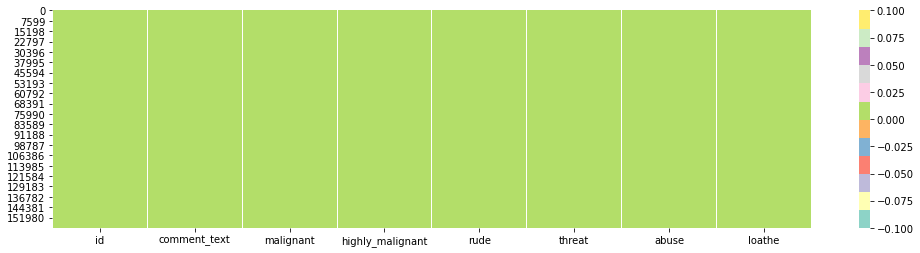

In [14]:
#In train Dataset
print("Total missing values in train dataset :",df.isnull().sum().sum())
plt.figure(figsize=(17,4))
sns.heatmap(df.isnull(),cmap="Set3")

Total missing values in test dataset : 0


<AxesSubplot:>

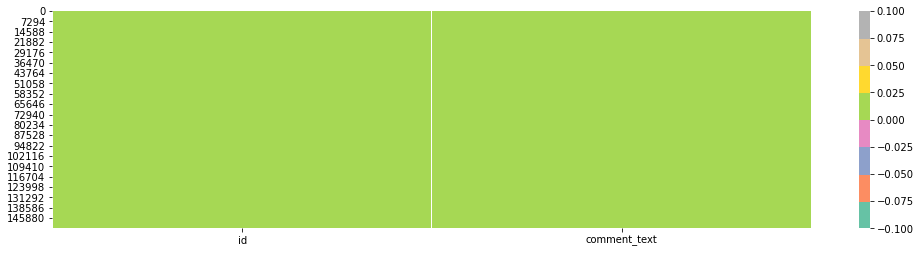

In [15]:
#In test Dataset
print("Total missing values in test dataset :",test.isnull().sum().sum())
plt.figure(figsize=(17,4))
sns.heatmap(test.isnull(),cmap="Set2")

Observation :  No Missing values

###### Droping Column

In [16]:
cmt=df.copy()
cmt.drop(['id'],axis=1,inplace=True)

In [17]:
test.drop(['id'],axis=1,inplace=True)

###### adding new columns

In [18]:
labels= ['malignant','highly_malignant','rude','threat','abuse','loathe']
cmt['normal']=1-cmt[labels].max(axis=1)

In [19]:
#adding a column 'raw length' to the dataset which will show the length of characters in column 'comment_text'
cmt['raw length']= cmt.comment_text.str.len().astype('int64')

In [20]:
cmt.head()

comment_text  malignant  \
0  Explanation\nWhy the edits made under my usern...          0   
1  D'aww! He matches this background colour I'm s...          0   
2  Hey man, I'm really not trying to edit war. It...          0   
3  "\nMore\nI can't make any real suggestions on ...          0   
4  You, sir, are my hero. Any chance you remember...          0   

   highly_malignant  rude  threat  abuse  loathe  normal  raw length  
0                 0     0       0      0       0       1         264  
1                 0     0       0      0       0       1         112  
2                 0     0       0      0       0       1         233  
3                 0     0       0      0       0       1         622  
4                 0     0       0      0       0       1          67

###### EDA

In [21]:
def addlabels(x,y):
    for i in range(x):
        plt.text(i, y[i], y[i], ha = 'center')

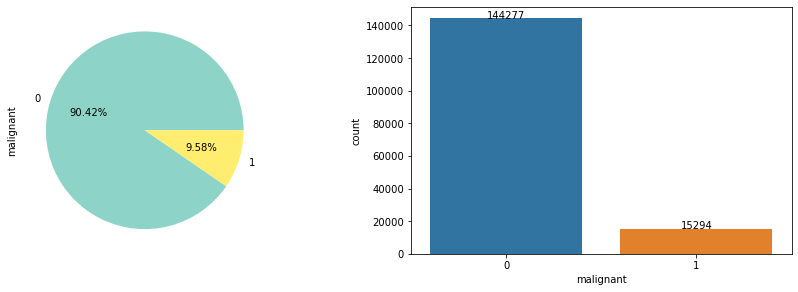

In [22]:
plt.figure(figsize=(15,10))
plt.subplot(2,2,1)
df['malignant'].value_counts().plot(kind = "pie",autopct='%1.2f%%',colormap='Set3')
plt.subplot(2,2,2)
sns.countplot(df['malignant'])
addlabels(df['malignant'].nunique(), df['malignant'].value_counts())

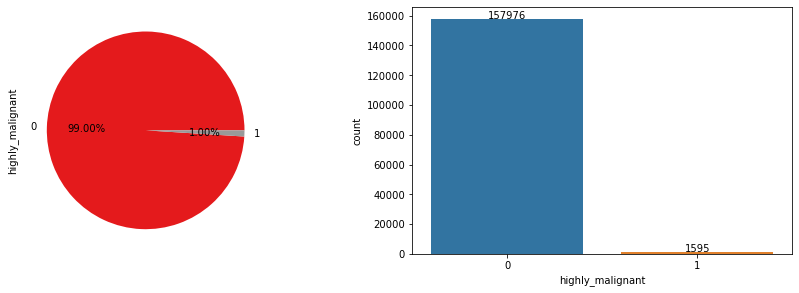

In [23]:
plt.figure(figsize=(15,10))
plt.subplot(2,2,1)
df['highly_malignant'].value_counts().plot(kind = "pie",autopct='%1.2f%%',colormap='Set1')
plt.subplot(2,2,2)
sns.countplot(df['highly_malignant'])
addlabels(df['highly_malignant'].nunique(), df['highly_malignant'].value_counts())

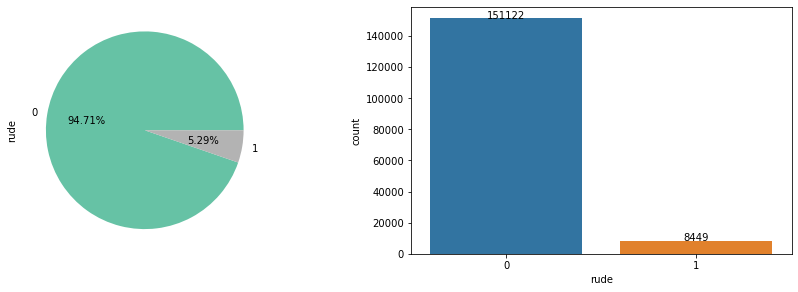

In [24]:
plt.figure(figsize=(15,10))
plt.subplot(2,2,1)
df['rude'].value_counts().plot(kind = "pie",autopct='%1.2f%%',colormap='Set2')
plt.subplot(2,2,2)
sns.countplot(df['rude'])
addlabels(df['rude'].nunique(), df['rude'].value_counts())

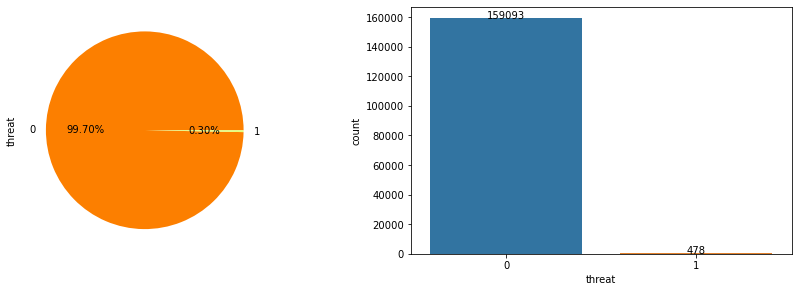

In [25]:
plt.figure(figsize=(15,10))
plt.subplot(2,2,1)
df['threat'].value_counts().plot(kind = "pie",autopct='%1.2f%%',colormap='Wistia_r')
plt.subplot(2,2,2)
sns.countplot(df['threat'])
addlabels(df['threat'].nunique(), df['threat'].value_counts())

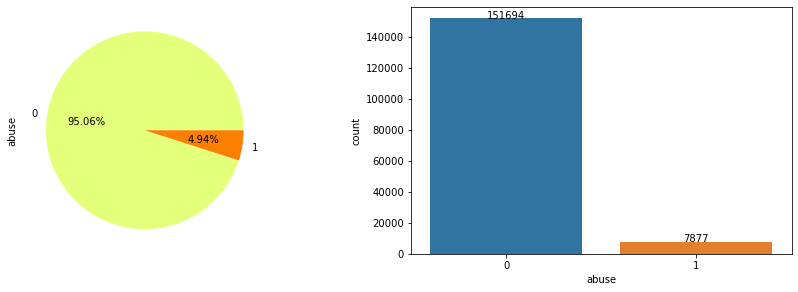

In [26]:
plt.figure(figsize=(15,10))
plt.subplot(2,2,1)
df['abuse'].value_counts().plot(kind = "pie",autopct='%1.2f%%',colormap='Wistia')
plt.subplot(2,2,2)
sns.countplot(df['abuse'])
addlabels(df['abuse'].nunique(), df['abuse'].value_counts())

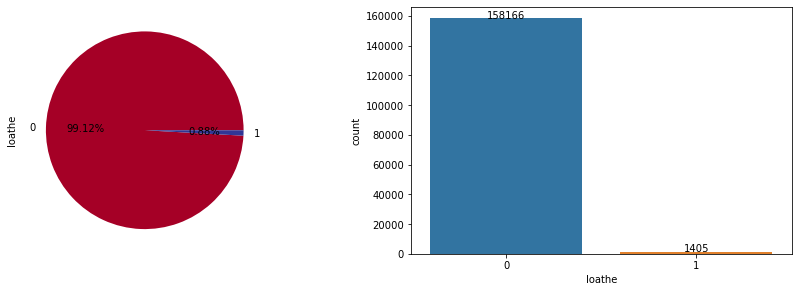

In [27]:
plt.figure(figsize=(15,10))
plt.subplot(2,2,1)
df['loathe'].value_counts().plot(kind = "pie",autopct='%1.2f%%',colormap='RdYlBu')
plt.subplot(2,2,2)
sns.countplot(df['loathe'])
addlabels(df['loathe'].nunique(), df['loathe'].value_counts())

<BarContainer object of 2 artists>

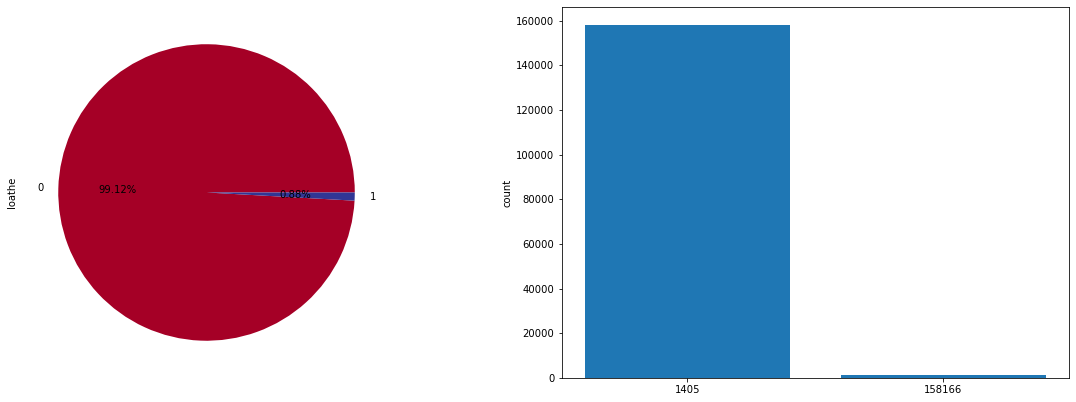

In [28]:
lvalues=[df.shape[0]-df.loathe.sum(),df.loathe.sum()]
label=['not loathe','loathe']
plt.figure(figsize=(20,15))
plt.subplot(2,2,1)
#plt.pie(x=lvalues,labels=label,autopct='%2.0f%%', colors=('coral','gold'))
df['loathe'].value_counts().plot(kind = "pie",autopct='%1.2f%%',colormap='RdYlBu')
plt.subplot(2,2,2)
sns.countplot(lvalues)
plt.bar(height=lvalues,x=label)

<BarContainer object of 2 artists>

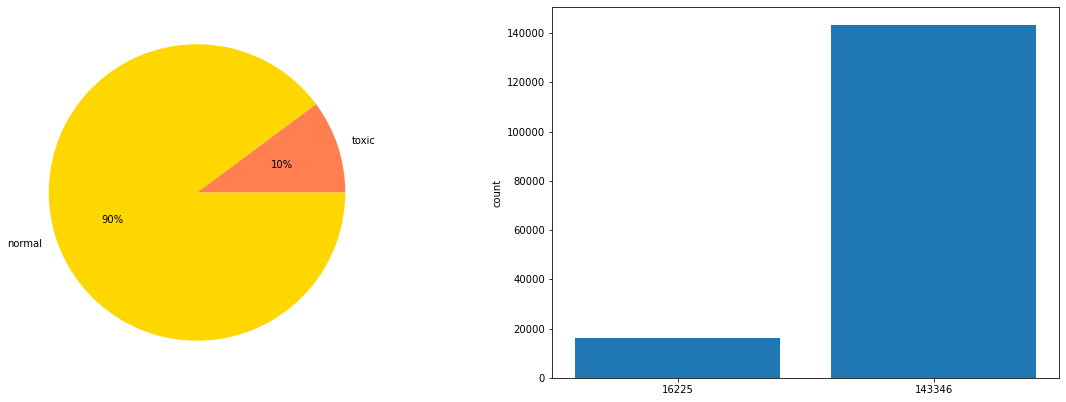

In [29]:
values=[cmt.shape[0]-cmt.normal.sum(),cmt.normal.sum()]
label=['toxic','normal']
plt.figure(figsize=(20,15))
plt.subplot(2,2,1)
plt.pie(x=values,labels=label,autopct='%2.0f%%', colors=('coral','gold'))
plt.subplot(2,2,2)
sns.countplot(values)
plt.bar(height=values,x=label)

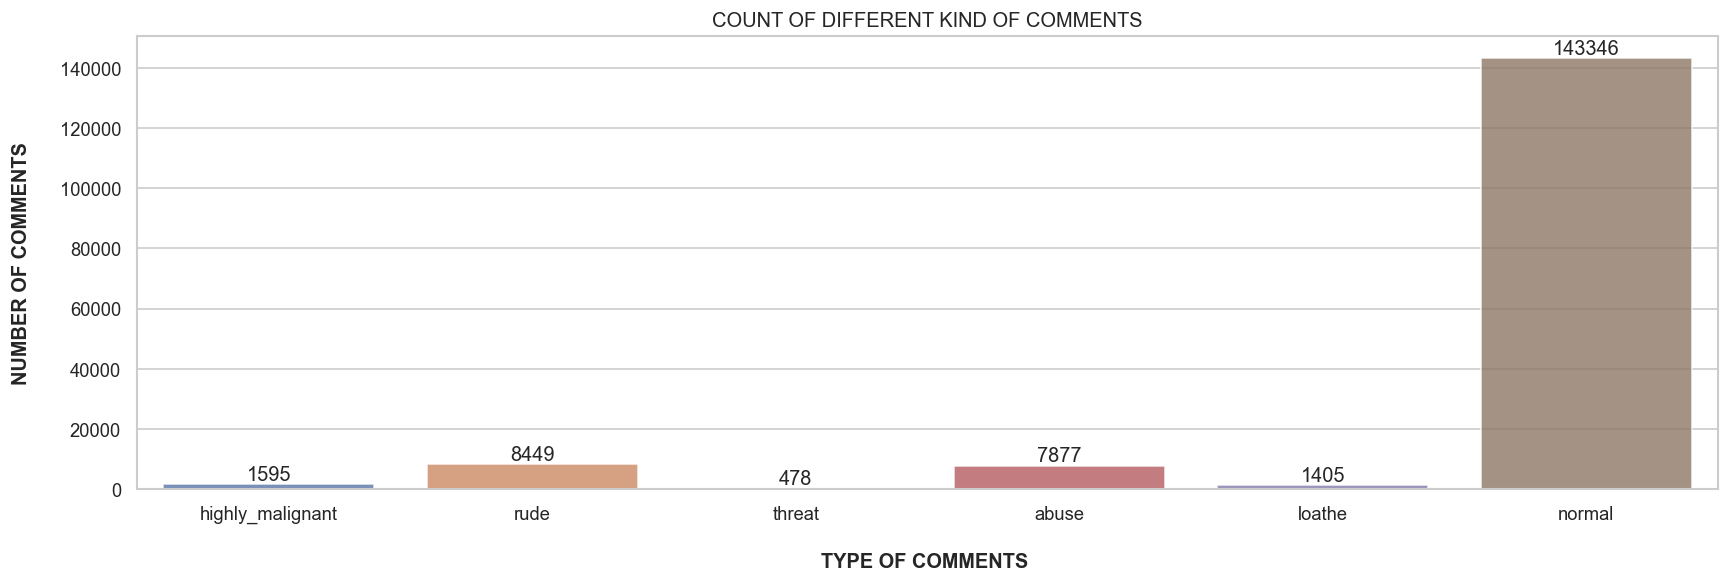

In [30]:
x=cmt.iloc[:,2:-1].sum() 
plt.figure(figsize=(17,5),dpi=120)
sns.set_context('talk',font_scale=0.4)
sns.set(style='whitegrid')
ax= sns.barplot(x.index, x.values, alpha=0.8)
plt.title("COUNT OF DIFFERENT KIND OF COMMENTS")
plt.ylabel('NUMBER OF COMMENTS\n', fontsize=12,weight='bold')
plt.xlabel('\nTYPE OF COMMENTS ', fontsize=12,weight='bold')
rects = ax.patches
labels = x.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')
plt.show()

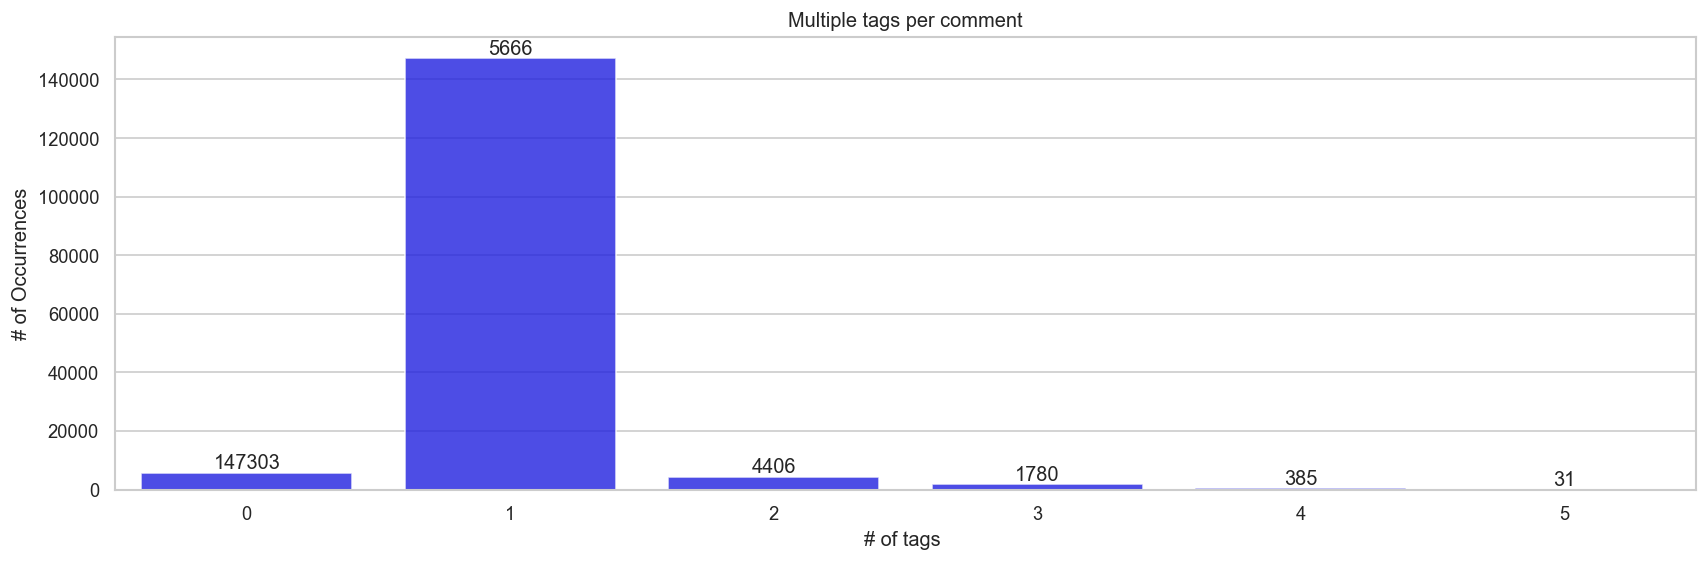

In [31]:
summation=cmt.iloc[:,2:-1].sum(axis=1) 
vc=summation.value_counts()
plt.figure(figsize=(17,5),dpi=120)
sns.set_context('talk',font_scale=0.4)
sns.set(style='whitegrid')
ax=sns.barplot(x=vc.index, y=vc.values, alpha=0.8,color='blue')
plt.title("Multiple tags per comment")
plt.ylabel('# of Occurrences', fontsize=12)
plt.xlabel('# of tags ', fontsize=12)
rects = ax.patches
labels = vc.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

plt.show()

###### Summary of dataset

In [32]:
cmt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 9 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   comment_text      159571 non-null  object
 1   malignant         159571 non-null  int64 
 2   highly_malignant  159571 non-null  int64 
 3   rude              159571 non-null  int64 
 4   threat            159571 non-null  int64 
 5   abuse             159571 non-null  int64 
 6   loathe            159571 non-null  int64 
 7   normal            159571 non-null  int64 
 8   raw length        159571 non-null  int64 
dtypes: int64(8), object(1)
memory usage: 11.0+ MB


In [33]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 153164 entries, 0 to 153163
Data columns (total 1 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   comment_text  153164 non-null  object
dtypes: object(1)
memory usage: 1.2+ MB


In [34]:
cmt.describe()

malignant  highly_malignant           rude         threat  \
count  159571.000000     159571.000000  159571.000000  159571.000000   
mean        0.095844          0.009996       0.052948       0.002996   
std         0.294379          0.099477       0.223931       0.054650   
min         0.000000          0.000000       0.000000       0.000000   
25%         0.000000          0.000000       0.000000       0.000000   
50%         0.000000          0.000000       0.000000       0.000000   
75%         0.000000          0.000000       0.000000       0.000000   
max         1.000000          1.000000       1.000000       1.000000   

               abuse         loathe         normal     raw length  
count  159571.000000  159571.000000  159571.000000  159571.000000  
mean        0.049364       0.008805       0.898321     394.138847  
std         0.216627       0.093420       0.302226     590.725381  
min         0.000000       0.000000       0.000000       5.000000  
25%         0.000000       0.000000       1.000000      96.000000  
50%         0.000000       0.000000       1.000000     205.000000  
75%         0.000000       0.000000       1.000000     436.000000  
max         1.000000       1.000000       1.000000    5000.000000

In [35]:
test.describe() 

comment_text
count                                153164
unique                               153164
top     whois|Vainavi Industries Ltd, India
freq                                      1

###### Data Cleaning

In [36]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [37]:
stopwords=['i','me','my','myself','we','our','ours','ourselves','you',"you're","you've","you'll","you'd",'yo','nothin','from','bein','u','ok','yup','youve',
           'your','yours','yourself','yourselves','he','him','his','himself','she',"she's",'her','hers','ur','mlm','nbfc',"he's",'ip','ja',"there's",'tyme','yep'
           'herself','it',"it's",'its','itself','they','them','their','theirs','themselves','what','which','lol','lool','fwiw','argh',"dont","i'll",'utc','too','y','u','r','doesnt'
           'who','whom','this','that',"that'll",'these','how','these','those','am','is','are','was','were','oh','hay','thanks','ty','wc','ha','hi','d','re','ll','there','someone','say',
           'be','been','being','have','has','had','having','do','does','did','done','doing','a','an','the','even','aww','bye!','bye','e','f','and','but','if','or','because','as','until','while','of','at','by','for','with','about','against',
           'between','into','through','during','before','after','above','below','to','from','up','down','in','out','on','off','over','under','again','further','then','once','here','there','when','where','why','how',
           'all','any','both','each','few','more','most','other','some','such','no','nor','not','only','own','same','so','than','too','very','s','t','can','will','just','don',"don't",'should',"should've",'now','d','ll','m',
           'o','re','ve','y','ain','aren',"aren't",'couldn',"couldn't",'didn',"didn't",'doesn',"doesn't",'hadn',"hadn't",'hasn',"hasn't",'haven',"haven't",'isn',"isn't",'ma','mightn',"mightn't",'mustn',"mustn't",'needn',
           "needn't",'shan',"shan't",'shouldn',"shouldn't",'wasn',"wasn't",'weren',"weren't",'won',"won't",'wouldn',"wouldn't", 'looked', "what's",'although','upright','bit','right','state',"i've",'much','more',
           "there's","You've",'got',"i'd",'everything','true','yes','moreover','would','could','like','mr.','but',"i'm",'able','back','get','still','ought','perhaps','without','away','onto','ive','let',
          'must','see','went','saw','many','whats','id','let','day','never','yet','im','go','thatll','theyre','came','youll','come','word','noone',"mrs.","now!","then?",'mr','ve','Â Â','january','days','february','march','april','may','june','july','august','september',
           'october','november','december','everyone','hey','ok','okay','cant','bbq','let','thats','also','time','name','oh','said','asked','anyone','however','wow','daww']

In [38]:
def preprocess(text):
    processed=[]
    lower=text.lower().replace(r'\n'," ").replace(r'^.+@[^\.].*\.[a-z]{2,}$',' ').replace(r'^http://[a-zA-Z0-9\-\.]+\.[a-zA-Z]{2,3}(/\S*)?$',' ')
    text=lower.replace(r'\s+', ' ').replace(r'\d+(\.\d+)?', ' ')
    text=lower.replace(r"[^a-zA-Z]+", " ").replace(r"—"," ").replace(r'“', ' ').replace(r'”',' ').replace('’',' ').replace(r'–',' ').replace('«', ' ').replace('»',' ')
    text=text.replace('®',' ').replace('´',' ').replace('·',' ').replace('½',' ').replace('¾',' ').replace('¤',' ')
    punct=text.translate(str.maketrans('', '', p)) 
    digit=punct.translate(str.maketrans('', '', d))     
    word= wt(digit, "english")
    for i in word:
        if i not in stopwords and len(i)>=3 and len(i)<12:
            lemma=porter().stem(wl().lemmatize(i))
            processed.append(lemma)
    return (" ".join([x for x in processed])).strip()

In [39]:
clean = []
for i in cmt.comment_text:
    clean.append(preprocess(i))

In [40]:
print("Length of cleaned text=\t",len(clean))

Length of cleaned text=	 159571


In [41]:
processed = pd.DataFrame({'comment' : clean })
cmt['comment']= processed
cmt['len of cleaned comment']=cmt['comment'].str.len().astype('int64')

In [42]:
print('Original Length = ',cmt['raw length'].sum())
print('Clean Length =  ', cmt['len of cleaned comment'].sum())
print('Total Reduction = ',cmt['raw length'].sum()-cmt['len of cleaned comment'].sum())

Original Length =  62893130
Clean Length =   29977753
Total Reduction =  32915377


In [43]:
cmt.head()

comment_text  malignant  \
0  Explanation\nWhy the edits made under my usern...          0   
1  D'aww! He matches this background colour I'm s...          0   
2  Hey man, I'm really not trying to edit war. It...          0   
3  "\nMore\nI can't make any real suggestions on ...          0   
4  You, sir, are my hero. Any chance you remember...          0   

   highly_malignant  rude  threat  abuse  loathe  normal  raw length  \
0                 0     0       0      0       0       1         264   
1                 0     0       0      0       0       1         112   
2                 0     0       0      0       0       1         233   
3                 0     0       0      0       0       1         622   
4                 0     0       0      0       0       1          67   

                                             comment  len of cleaned comment  
0  explan edit made usernam hardcor metallica fan...                     141  
1       match background colour seemingli stuck talk                      44  
2  man realli tri edit war guy constantli remov r...                     114  
3  make real suggest improv wonder section statis...                     250  
4                         sir hero chanc rememb page                      26

In [44]:
comments = []
for i in test.comment_text:
    comments.append(preprocess(i))

In [45]:
processed = pd.DataFrame({'comment' : comments })
test['comment']= processed

In [46]:
test.head()

comment_text  \
0  Yo bitch Ja Rule is more succesful then you'll...   
1  == From RfC == \n\n The title is fine as it is...   
2  " \n\n == Sources == \n\n * Zawe Ashton on Lap...   
3  :If you have a look back at the source, the in...   
4          I don't anonymously edit articles at all.   

                                             comment  
0  bitch rule succes ever hate sad mofuckasi bitc...  
1                                  rfc titl fine imo  
2                           sourc zaw ashton lapland  
3  look sourc inform updat correct form guess sou...  
4                                 anonym edit articl

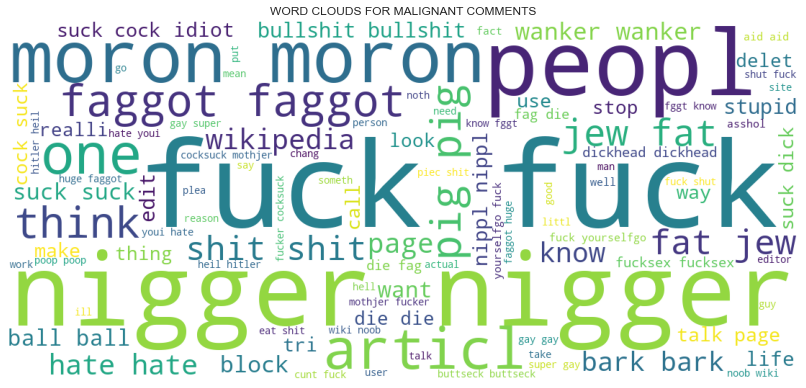

In [126]:
malignant = cmt['comment'][cmt['malignant']==1]
wordcloud = WordCloud(width=1100,height=500,background_color='white',max_words=100).generate(' '.join(malignant))
plt.figure(figsize = (15,5), facecolor = 'white', edgecolor='blue') 
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.title('WORD CLOUDS FOR MALIGNANT COMMENTS')
plt.show()

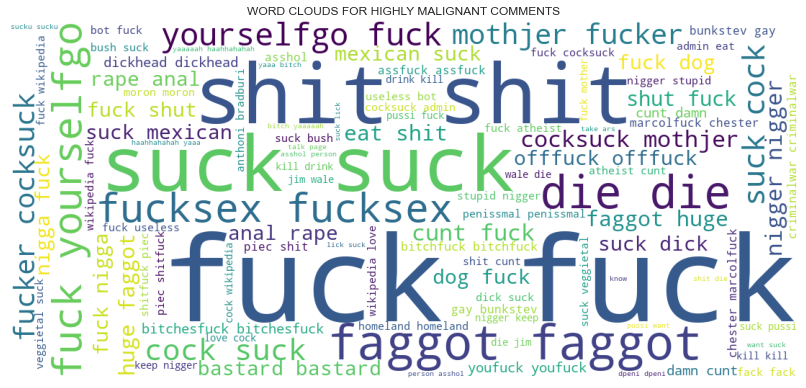

In [127]:
highly_malignant = cmt['comment'][cmt['highly_malignant']==1]
wordcloud = WordCloud(width=1100,height=500,background_color='white',max_words=100).generate(' '.join(highly_malignant))
plt.figure(figsize = (15,5), facecolor = 'white', edgecolor='green') 
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.title('WORD CLOUDS FOR HIGHLY MALIGNANT COMMENTS')
plt.show()


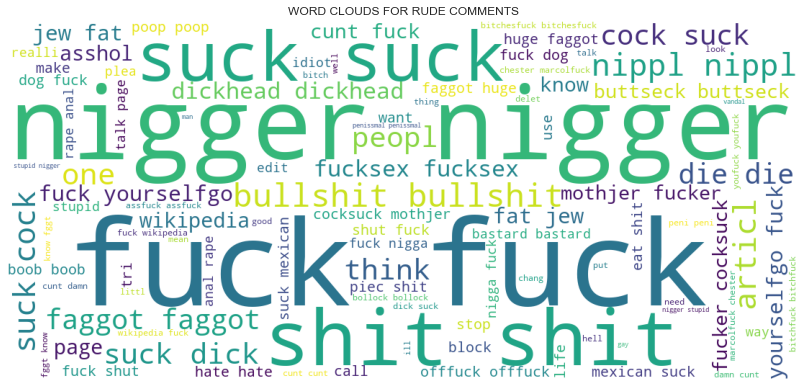

In [128]:
rude = cmt['comment'][cmt['rude']==1]
wordcloud = WordCloud(width=1100,height=500,background_color='white',max_words=100).generate(' '.join(rude))
plt.figure(figsize = (15,5), facecolor = 'white', edgecolor='purple') 
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.title('WORD CLOUDS FOR RUDE COMMENTS')
plt.show()


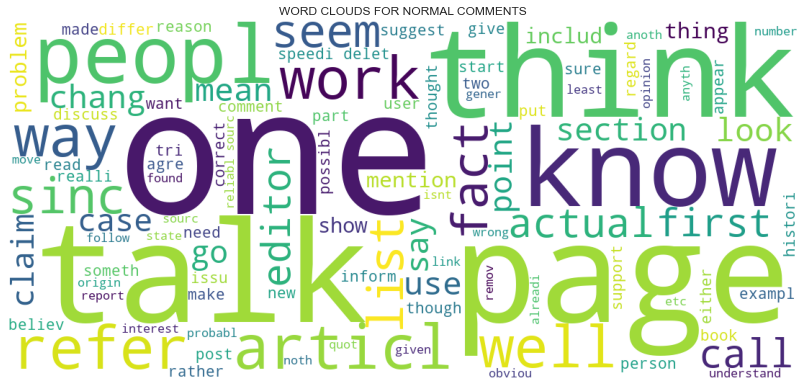

In [129]:
normal = cmt['comment'][cmt['normal']==1]
wordcloud = WordCloud(width=1100,height=500,background_color='white',max_words=100).generate(' '.join(normal))
plt.figure(figsize = (15,5), facecolor = 'white', edgecolor='red') 
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.title('WORD CLOUDS FOR NORMAL COMMENTS')
plt.show()


In [47]:
cmt.sample(4)

comment_text  malignant  \
39930   These events are fictional. What real-world in...          0   
108295  Welcome!\n\nHello, , and welcome to Wikipedia!...          0   
158465  "\nOddly enough, I am truly agnostic on this p...          0   
113874  Further please note that the vitiated nature o...          0   

        highly_malignant  rude  threat  abuse  loathe  normal  raw length  \
39930                  0     0       0      0       0       1          80   
108295                 0     0       0      0       0       1        1402   
158465                 0     0       0      0       0       1        4218   
113874                 0     0       0      0       0       1         114   

                                                  comment  \
39930                      event fiction realworld inform   
108295  welcom hello welcom wikipedia thank hope place...   
158465  oddli enough truli agnost particular softwar a...   
113874    pleas note vitiat natur call documentari stress   

        len of cleaned comment  
39930                       30  
108295                     732  
158465                    1869  
113874                      47

###### split Independent and Dependent variables

In [48]:
X=cmt.comment
y=cmt.iloc[:,1:-3]

In [49]:
X.head()

0    explan edit made usernam hardcor metallica fan...
1         match background colour seemingli stuck talk
2    man realli tri edit war guy constantli remov r...
3    make real suggest improv wonder section statis...
4                           sir hero chanc rememb page
Name: comment, dtype: object

In [50]:
y.head()

malignant  highly_malignant  rude  threat  abuse  loathe  normal
0          0                 0     0       0      0       0       1
1          0                 0     0       0      0       0       1
2          0                 0     0       0      0       0       1
3          0                 0     0       0      0       0       1
4          0                 0     0       0      0       0       1

In [51]:
tfidf=tf(input='content', encoding='utf-8', lowercase=True,stop_words='english',max_features=1000,ngram_range=(1,3))

In [52]:
x=tfidf.fit_transform(X).toarray()

###### selected features

In [53]:
tfidf.get_feature_names()[1:9]

['abus', 'academ', 'accept', 'access', 'accord', 'account', 'accur', 'accus']

###### Split into train and test set

In [54]:
x_train,x_test,y_train,y_test=tts(x,y,test_size = 0.25, random_state = 44)

In [55]:
print('shape of x_train:',x_train.shape)
print('shape of x_test:',x_test.shape)

shape of x_train: (119678, 1000)
shape of x_test: (39893, 1000)


In [56]:
print('shape of y_train:',y_train.shape)
print('shape of y_test:',y_test.shape)

shape of y_train: (119678, 7)
shape of y_test: (39893, 7)


In [65]:
labels=['malignant','highly_malignant','rude','threat','abuse','loathe','normal']

###### Model Training

In [66]:
from sklearn.ensemble import GradientBoostingClassifier,RandomForestClassifier,AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

Processing malignant
-------------------------------------
ACCURACY SCORE: 0.9514451156844559

F1 score: 0.6817808444225397

CLASSIFICATION REPORT:
               precision    recall  f1-score   support

           0       0.95      0.99      0.97     36121
           1       0.90      0.55      0.68      3772

    accuracy                           0.95     39893
   macro avg       0.93      0.77      0.83     39893
weighted avg       0.95      0.95      0.95     39893


PRECISION:
 0.896328293736501

RECALL:
 0.5501060445387063

MEAN SQUARED ERROR:
 0.04855488431554408

ROOT MEAN SQ. ERROR:
 0.2203517286420601

LOG_LOSS: 1.6770311027078755

AUC_ROC Score:
 0.7717308551089754

TPR: [0.         0.00664433 1.        ] 
FPR: [0.         0.55010604 1.        ]




	____________________________________________ROC_AUC CURVE_______________________________________________



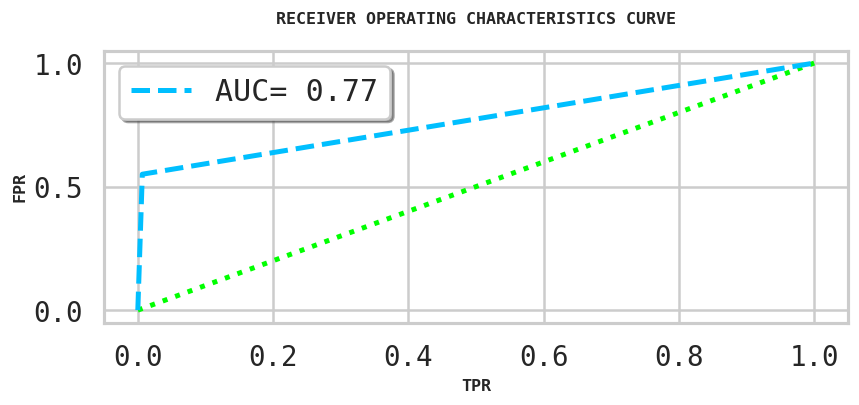





	____________________________________________CONFUSION MATRIX___________________________________________



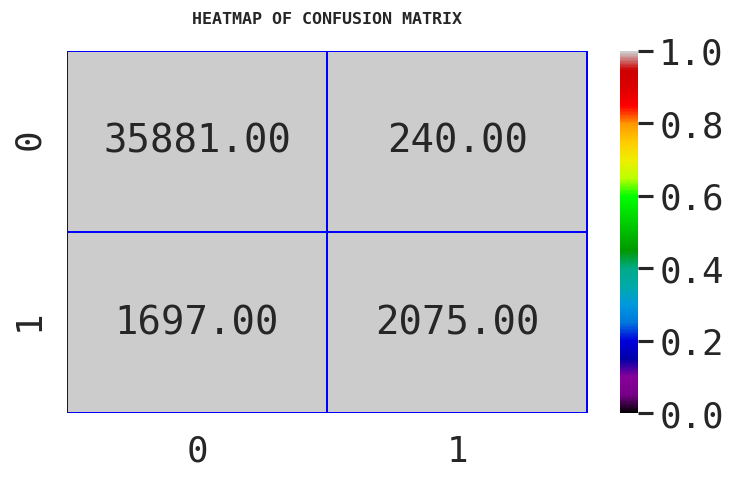



Processing highly_malignant
-------------------------------------
ACCURACY SCORE: 0.9908254581004187

F1 score: 0.2879377431906615

CLASSIFICATION REPORT:
               precision    recall  f1-score   support

           0       0.99      1.00      1.00     39532
           1       0.48      0.20      0.29       361

    accuracy                           0.99     39893
   macro avg       0.74      0.60      0.64     39893
weighted avg       0.99      0.99      0.99     39893


PRECISION:
 0.48366013071895425

RECALL:
 0.20498614958448755

MEAN SQUARED ERROR:
 0.00917454189958138

ROOT MEAN SQ. ERROR:
 0.09578382900877047

LOG_LOSS: 0.31687903463600964

AUC_ROC Score:
 0.6014938842630522

TPR: [0.         0.00199838 1.        ] 
FPR: [0.         0.20498615 1.        ]




	____________________________________________ROC_AUC CURVE_______________________________________________



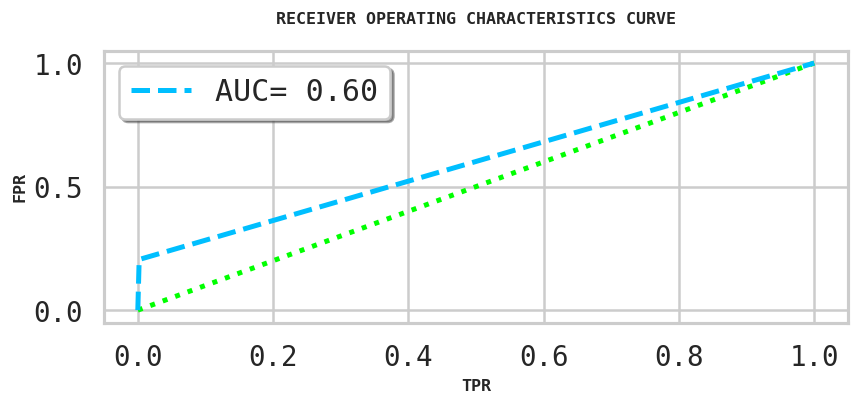





	____________________________________________CONFUSION MATRIX___________________________________________



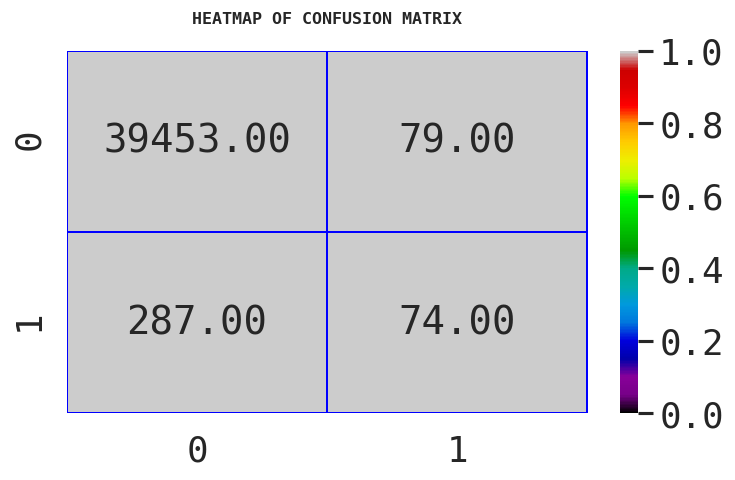



Processing rude
-------------------------------------
ACCURACY SCORE: 0.9765873712180082

F1 score: 0.7349602724177072

CLASSIFICATION REPORT:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99     37832
           1       0.89      0.63      0.73      2061

    accuracy                           0.98     39893
   macro avg       0.93      0.81      0.86     39893
weighted avg       0.98      0.98      0.97     39893


PRECISION:
 0.8851674641148325

RECALL:
 0.6283357593401262

MEAN SQUARED ERROR:
 0.023412628781991827

ROOT MEAN SQ. ERROR:
 0.15301185830513864

LOG_LOSS: 0.8086469176350458

AUC_ROC Score:
 0.8119475371029242

TPR: [0.         0.00444069 1.        ] 
FPR: [0.         0.62833576 1.        ]




	____________________________________________ROC_AUC CURVE_______________________________________________



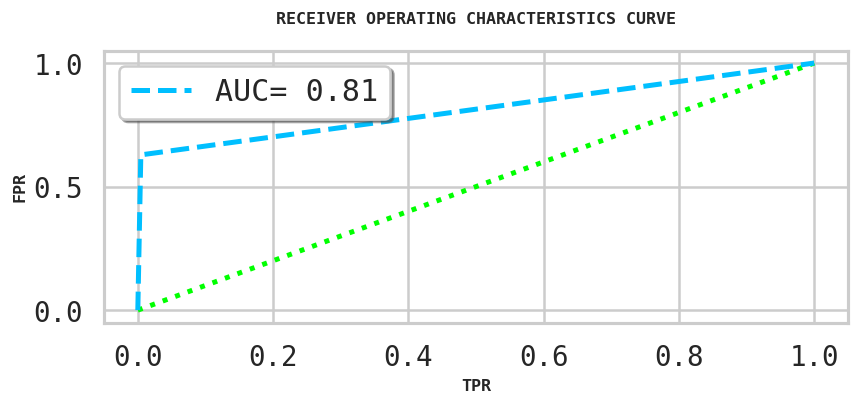





	____________________________________________CONFUSION MATRIX___________________________________________



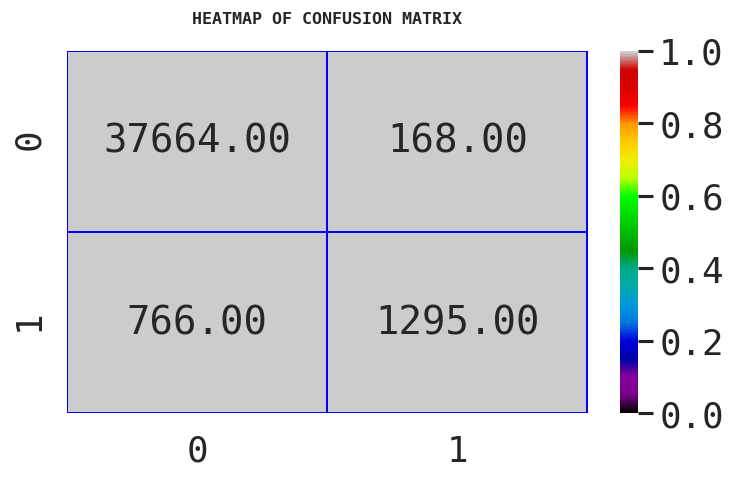



Processing threat
-------------------------------------
ACCURACY SCORE: 0.9973178251823628

F1 score: 0.13008130081300812

CLASSIFICATION REPORT:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     39786
           1       0.50      0.07      0.13       107

    accuracy                           1.00     39893
   macro avg       0.75      0.54      0.56     39893
weighted avg       1.00      1.00      1.00     39893


PRECISION:
 0.5

RECALL:
 0.07476635514018691

MEAN SQUARED ERROR:
 0.0026821748176371796

ROOT MEAN SQ. ERROR:
 0.051789717296362794

LOG_LOSS: 0.09263919662684994

AUC_ROC Score:
 0.537282639692448

TPR: [0.00000000e+00 2.01075755e-04 1.00000000e+00] 
FPR: [0.         0.07476636 1.        ]




	____________________________________________ROC_AUC CURVE_______________________________________________



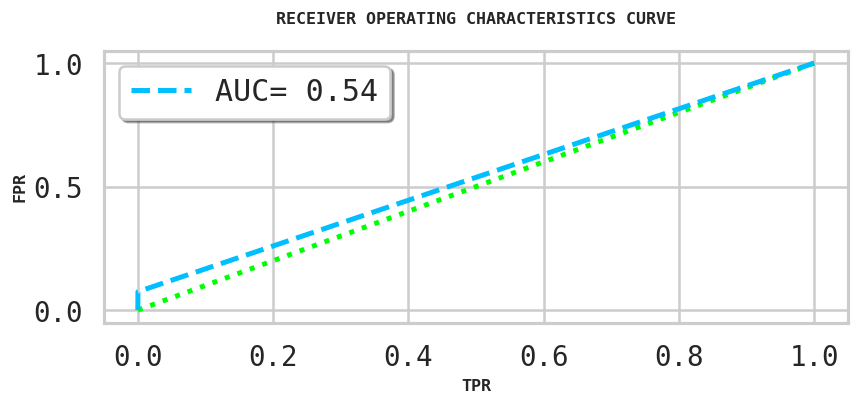





	____________________________________________CONFUSION MATRIX___________________________________________



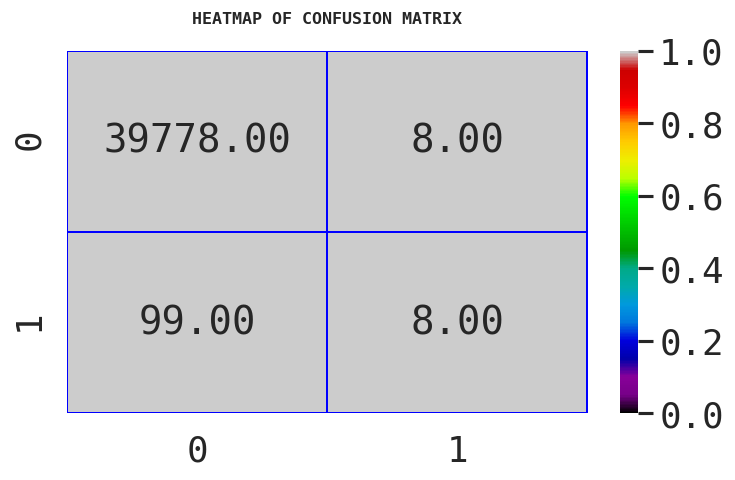



Processing abuse
-------------------------------------
ACCURACY SCORE: 0.9682149750582809

F1 score: 0.6030056355666876

CLASSIFICATION REPORT:
               precision    recall  f1-score   support

           0       0.97      0.99      0.98     37916
           1       0.79      0.49      0.60      1977

    accuracy                           0.97     39893
   macro avg       0.88      0.74      0.79     39893
weighted avg       0.96      0.97      0.96     39893


PRECISION:
 0.7912900575184881

RECALL:
 0.48710166919575115

MEAN SQUARED ERROR:
 0.0317850249417191

ROOT MEAN SQ. ERROR:
 0.17828355207847724

LOG_LOSS: 1.0978209602309692

AUC_ROC Score:
 0.7402013251559514

TPR: [0.         0.00669902 1.        ] 
FPR: [0.         0.48710167 1.        ]




	____________________________________________ROC_AUC CURVE_______________________________________________



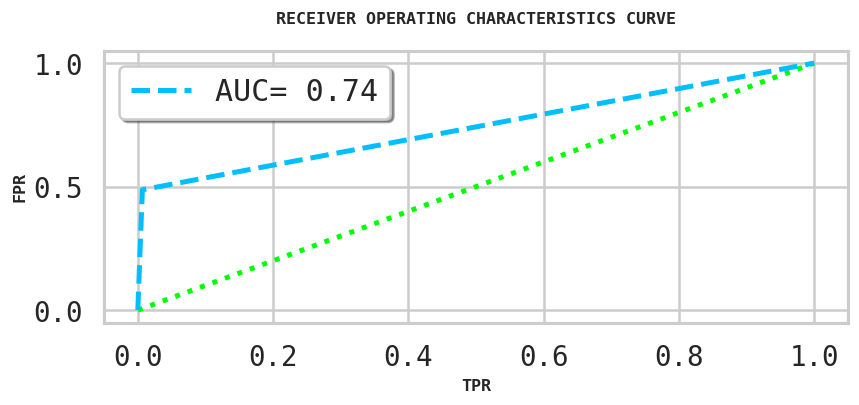





	____________________________________________CONFUSION MATRIX___________________________________________



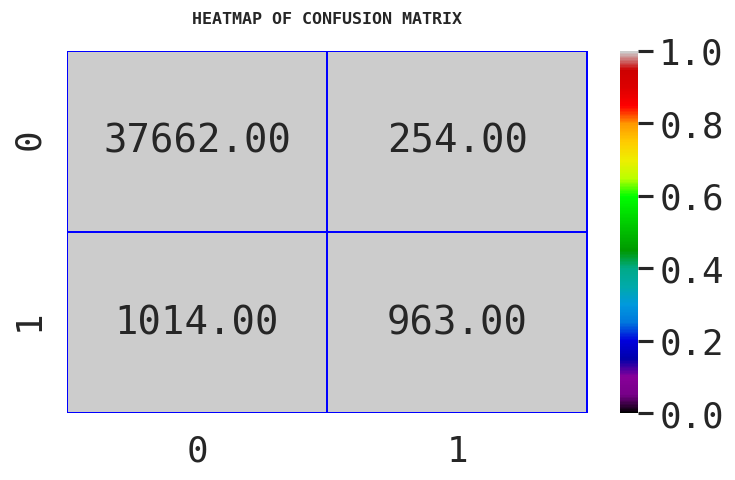



Processing loathe
-------------------------------------
ACCURACY SCORE: 0.9919785426014589

F1 score: 0.31034482758620685

CLASSIFICATION REPORT:
               precision    recall  f1-score   support

           0       0.99      1.00      1.00     39544
           1       0.63      0.21      0.31       349

    accuracy                           0.99     39893
   macro avg       0.81      0.60      0.65     39893
weighted avg       0.99      0.99      0.99     39893


PRECISION:
 0.6260869565217392

RECALL:
 0.20630372492836677

MEAN SQUARED ERROR:
 0.008021457398541097

ROOT MEAN SQ. ERROR:
 0.08956258928001745

LOG_LOSS: 0.27705218532226095

AUC_ROC Score:
 0.6026081643051707

TPR: [0.        0.0010874 1.       ] 
FPR: [0.         0.20630372 1.        ]




	____________________________________________ROC_AUC CURVE_______________________________________________



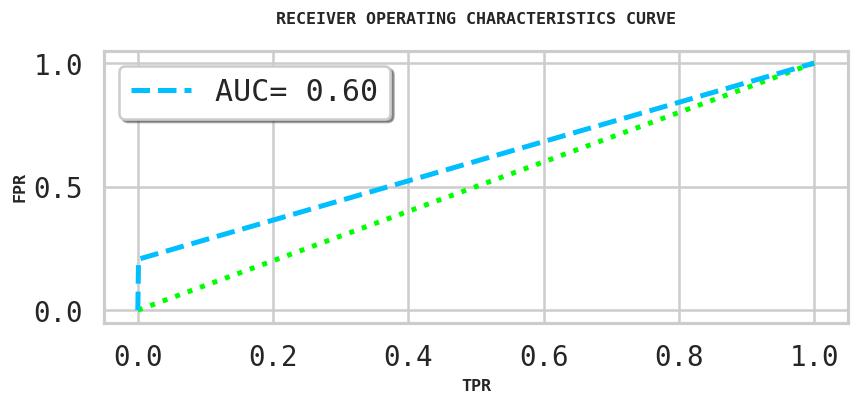





	____________________________________________CONFUSION MATRIX___________________________________________



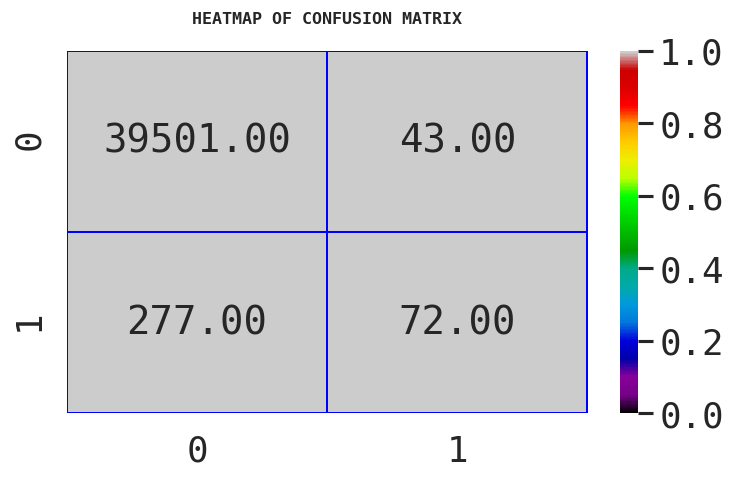



Processing normal
-------------------------------------
ACCURACY SCORE: 0.9494898854435615

F1 score: 0.9725128568895195

CLASSIFICATION REPORT:
               precision    recall  f1-score   support

           0       0.91      0.56      0.69      4013
           1       0.95      0.99      0.97     35880

    accuracy                           0.95     39893
   macro avg       0.93      0.77      0.83     39893
weighted avg       0.95      0.95      0.94     39893


PRECISION:
 0.9524140326502257

RECALL:
 0.9934782608695653

MEAN SQUARED ERROR:
 0.050510114556438473

ROOT MEAN SQ. ERROR:
 0.22474455400840856

LOG_LOSS: 1.7445932499127224

AUC_ROC Score:
 0.7748353178257619

TPR: [0.         0.44380763 1.        ] 
FPR: [0.         0.99347826 1.        ]




	____________________________________________ROC_AUC CURVE_______________________________________________



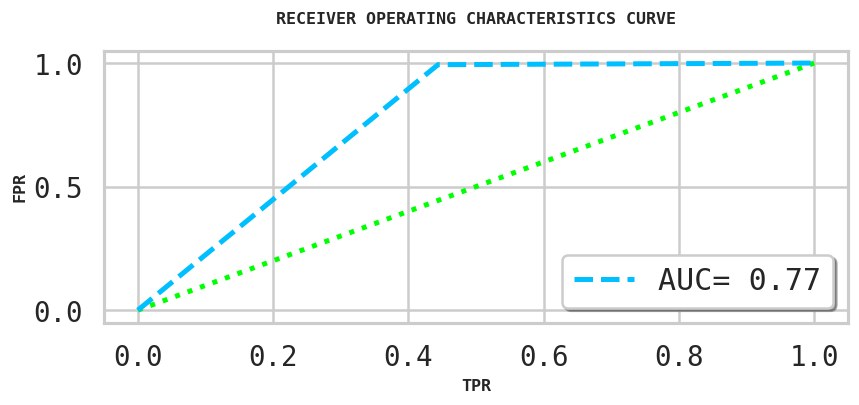





	____________________________________________CONFUSION MATRIX___________________________________________



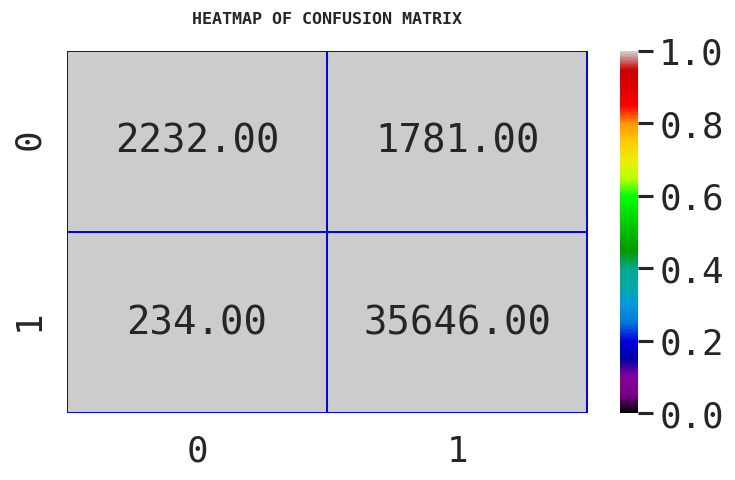

In [67]:
LogReg_pipeline = Pipeline([('clf', OneVsRestClassifier(LogisticRegression(solver='sag'), n_jobs=1))])
F1=[]
ACCURACY = []
PRECESION = []
RECALL = []
RMSE = []
MSE = []
AUC=[]
TPR=[]
FPR=[]
CV_ACC=[]
LOG_LOSS=[]

for category in labels:
    print('Processing {}'.format(category),"\n-------------------------------------")
    LogReg_pipeline.fit(x_train, y_train[category])
    pred = LogReg_pipeline.predict(x_test)
    
    f1=f1_score(pred,y_test[category])
    acc=accuracy_score(pred,y_test[category])
    clr=classification_report(y_test[category],pred)
    pre=precision_score(y_test[category],pred)
    rec=recall_score(y_test[category],pred)
    mse=mean_squared_error(y_test[category],pred)
    rmse=np.sqrt(mse)
    log = log_loss( y_test[category],pred)
    auc_scr=roc_auc_score(y_test[category],pred)
    tpr,fpr,threshold=roc_curve(y_test[category],pred)
    conf=confusion_matrix(y_test[category],pred)
    print('ACCURACY SCORE:', acc)
    print('\nF1 score:',f1)
    print('\nCLASSIFICATION REPORT:\n',clr)
    print('\nPRECISION:\n',pre)
    print('\nRECALL:\n',rec)
    print('\nMEAN SQUARED ERROR:\n',mse)
    print('\nROOT MEAN SQ. ERROR:\n',rmse)
    print('\nLOG_LOSS:',log)
    print('\nAUC_ROC Score:\n',auc_scr)
    print('\nTPR:',tpr,'\nFPR:',fpr,'\n')
    
    
    print('\n\n\t____________________________________________ROC_AUC CURVE_______________________________________________')
    
    sns.set(context='talk',style='whitegrid',palette='dark',font='monospace',font_scale=1)
    plt.figure(figsize=(8,3),dpi=120)
    plt.plot([0,1],[0,1],color='lime',linestyle=":",lw=3)
    plt.plot(tpr,fpr,label="AUC= %0.2f" % auc_scr,color='deepskyblue',lw=3,linestyle='--')
    plt.legend(fancybox=True,shadow=True, fontsize='medium')
    
    plt.xlabel("TPR",weight='bold',fontsize=10)
    plt.ylabel('FPR',weight='bold',fontsize=10)
    plt.title('RECEIVER OPERATING CHARACTERISTICS CURVE\n',size=10,weight='bold',loc='center')
    plt.show()
    
    
    print('\n\n\n\t____________________________________________CONFUSION MATRIX___________________________________________\n')
    sns.set(context='talk',style='whitegrid',palette='dark',font='monospace',font_scale=1.3)
    plt.figure(figsize=(7,4),dpi=120)
    sns.heatmap(conf,annot=True,fmt='.2f',vmax=1,vmin=0,cmap='nipy_spectral',linewidths=0.8, linecolor='blue')
    plt.title('HEATMAP OF CONFUSION MATRIX\n',size=10,weight='bold',loc='center')
    plt.show()
    print('\n')
    
    ACCURACY.append(acc)
    F1.append(f1)
    PRECESION.append(pre)
    RECALL.append(rec)
    RMSE.append(rmse)
    MSE.append(mse)
    AUC.append(auc_scr)
    TPR.append(tpr)
    FPR.append(fpr)
    LOG_LOSS.append(log)

logi_results = pd.DataFrame({"LABELS":labels,"F1":F1,'Acuracy':ACCURACY,'Precision': PRECESION ,'Recall': RECALL,
                               'RMSE':RMSE,'MSE':MSE,'AUC':AUC,'LOG_LOSS':LOG_LOSS})
logi_results.style.set_properties(**{'background-color':'midnightblue','color': 'lime','border-color': 'darkorange'})

Processing malignant
-------------------------------------
ACCURACY SCORE: 0.9473090517133331

F1 score: 0.6355755894590847

CLASSIFICATION REPORT:
               precision    recall  f1-score   support

           0       0.95      1.00      0.97     36121
           1       0.92      0.49      0.64      3772

    accuracy                           0.95     39893
   macro avg       0.93      0.74      0.80     39893
weighted avg       0.95      0.95      0.94     39893


PRECISION:
 0.9183366733466933

RECALL:
 0.485949098621421

MEAN SQUARED ERROR:
 0.05269094828666683

ROOT MEAN SQ. ERROR:
 0.22954508987705843

LOG_LOSS: 1.8198841480080068

AUC_ROC Score:
 0.7407182441142873

TPR: [0.         0.00451261 1.        ] 
FPR: [0.        0.4859491 1.       ]




	____________________________________________ROC_AUC CURVE_______________________________________________



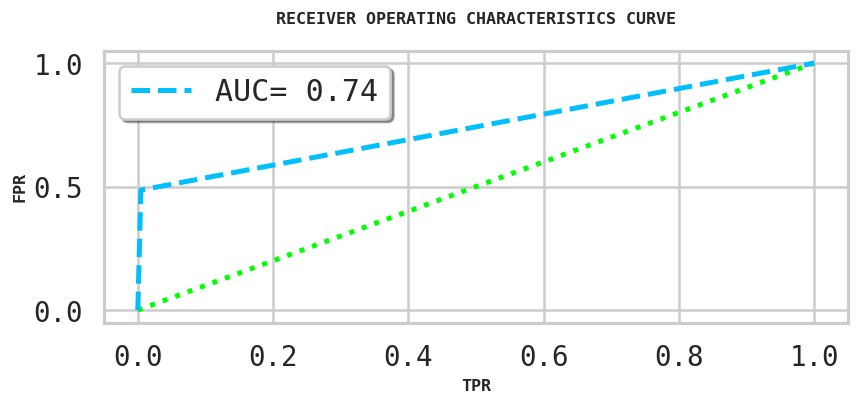





	____________________________________________CONFUSION MATRIX___________________________________________



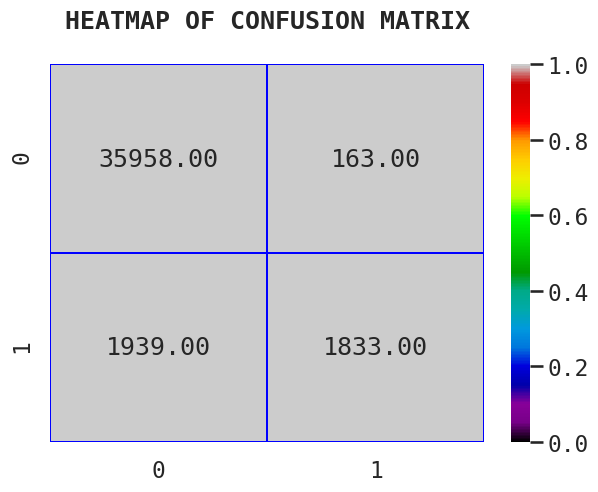



Processing highly_malignant
-------------------------------------
ACCURACY SCORE: 0.9883688867721154

F1 score: 0.3608815426997245

CLASSIFICATION REPORT:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99     39532
           1       0.36      0.36      0.36       361

    accuracy                           0.99     39893
   macro avg       0.68      0.68      0.68     39893
weighted avg       0.99      0.99      0.99     39893


PRECISION:
 0.3589041095890411

RECALL:
 0.3628808864265928

MEAN SQUARED ERROR:
 0.011631113227884592

ROOT MEAN SQ. ERROR:
 0.10784763895368592

LOG_LOSS: 0.40172910919302285

AUC_ROC Score:
 0.6784808155698683

TPR: [0.         0.00591926 1.        ] 
FPR: [0.         0.36288089 1.        ]




	____________________________________________ROC_AUC CURVE_______________________________________________



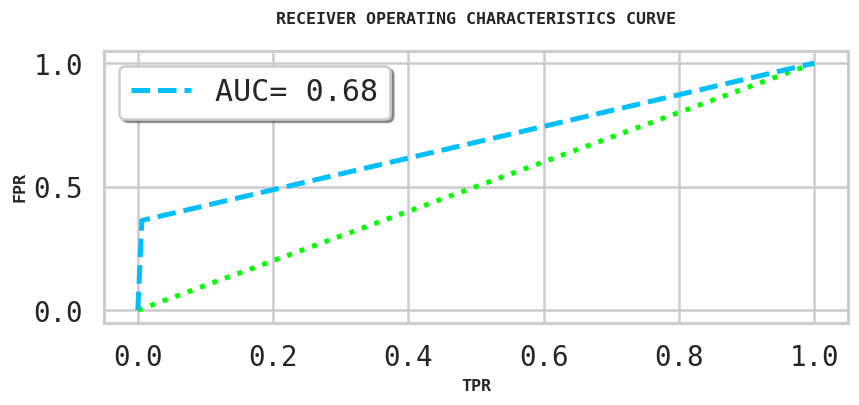





	____________________________________________CONFUSION MATRIX___________________________________________



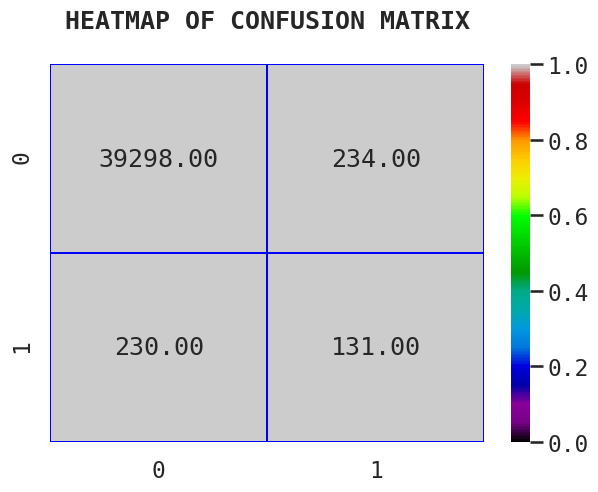



Processing rude
-------------------------------------
ACCURACY SCORE: 0.9755596219888201

F1 score: 0.736129905277402

CLASSIFICATION REPORT:
               precision    recall  f1-score   support

           0       0.98      0.99      0.99     37832
           1       0.83      0.66      0.74      2061

    accuracy                           0.98     39893
   macro avg       0.91      0.83      0.86     39893
weighted avg       0.97      0.98      0.97     39893


PRECISION:
 0.8323133414932681

RECALL:
 0.6598738476467734

MEAN SQUARED ERROR:
 0.024440378011179906

ROOT MEAN SQ. ERROR:
 0.15633418695595633

LOG_LOSS: 0.844146243068554

AUC_ROC Score:
 0.8263156508269816

TPR: [0.         0.00724255 1.        ] 
FPR: [0.         0.65987385 1.        ]




	____________________________________________ROC_AUC CURVE_______________________________________________



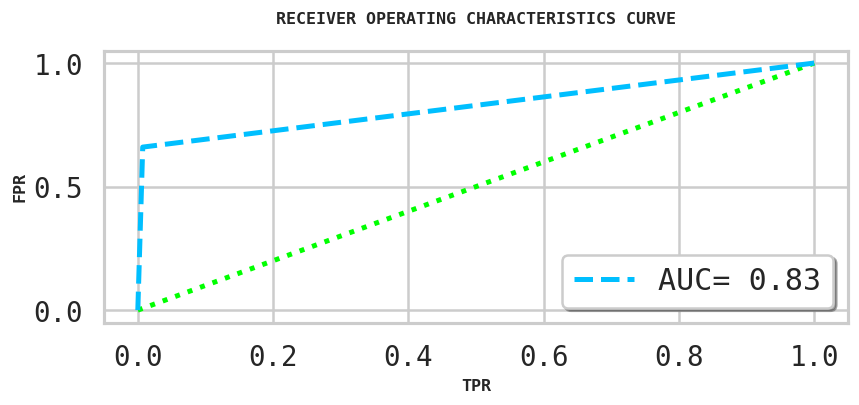





	____________________________________________CONFUSION MATRIX___________________________________________



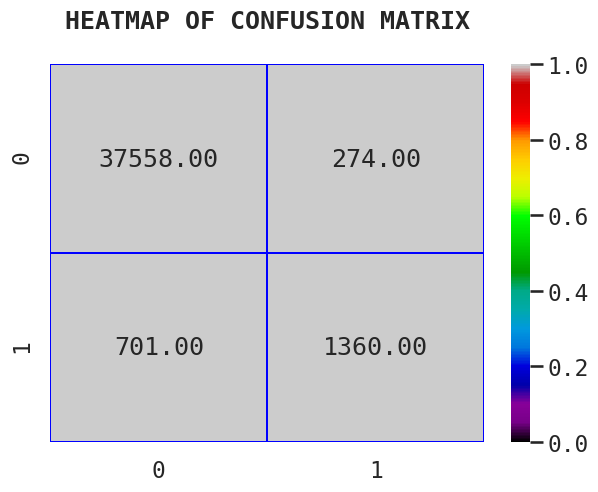



Processing threat
-------------------------------------
ACCURACY SCORE: 0.9962399418444339

F1 score: 0.34782608695652173

CLASSIFICATION REPORT:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     39786
           1       0.33      0.37      0.35       107

    accuracy                           1.00     39893
   macro avg       0.66      0.69      0.67     39893
weighted avg       1.00      1.00      1.00     39893


PRECISION:
 0.3252032520325203

RECALL:
 0.37383177570093457

MEAN SQUARED ERROR:
 0.0037600581555661395

ROOT MEAN SQ. ERROR:
 0.061319313071544916

LOG_LOSS: 0.1298694714817975

AUC_ROC Score:
 0.6858728073698962

TPR: [0.         0.00208616 1.        ] 
FPR: [0.         0.37383178 1.        ]




	____________________________________________ROC_AUC CURVE_______________________________________________



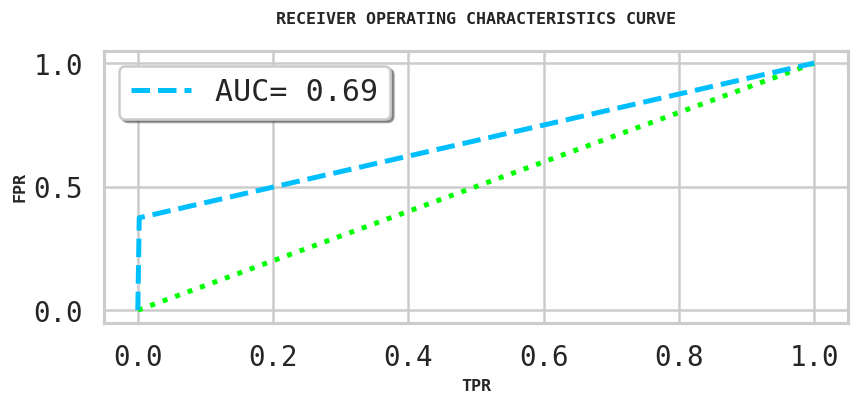





	____________________________________________CONFUSION MATRIX___________________________________________



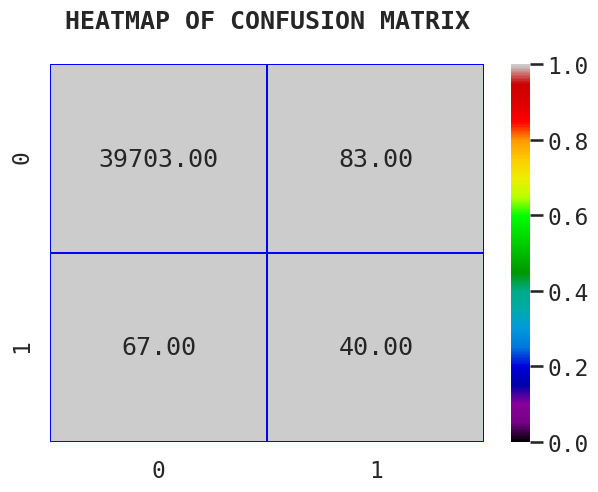



Processing abuse
-------------------------------------
ACCURACY SCORE: 0.9665354824154614

F1 score: 0.6039750815781667

CLASSIFICATION REPORT:
               precision    recall  f1-score   support

           0       0.98      0.99      0.98     37916
           1       0.73      0.51      0.60      1977

    accuracy                           0.97     39893
   macro avg       0.85      0.75      0.79     39893
weighted avg       0.96      0.97      0.96     39893


PRECISION:
 0.7302725968436155

RECALL:
 0.514921598381386

MEAN SQUARED ERROR:
 0.03346451758453864

ROOT MEAN SQ. ERROR:
 0.1829330959245446

LOG_LOSS: 1.1558310263915863

AUC_ROC Score:
 0.7525024702530413

TPR: [0.         0.00991666 1.        ] 
FPR: [0.        0.5149216 1.       ]




	____________________________________________ROC_AUC CURVE_______________________________________________



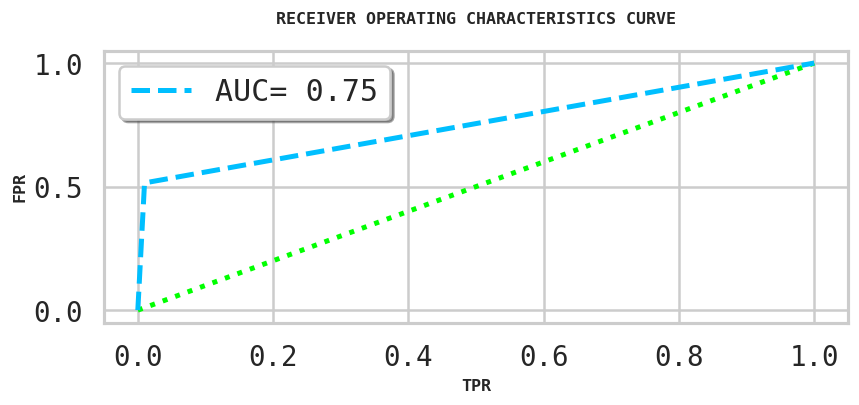





	____________________________________________CONFUSION MATRIX___________________________________________



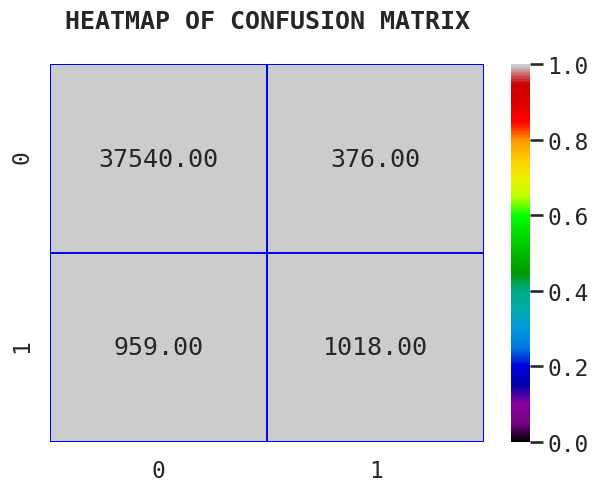



Processing loathe
-------------------------------------
ACCURACY SCORE: 0.9915774697315318

F1 score: 0.30864197530864196

CLASSIFICATION REPORT:
               precision    recall  f1-score   support

           0       0.99      1.00      1.00     39544
           1       0.55      0.21      0.31       349

    accuracy                           0.99     39893
   macro avg       0.77      0.61      0.65     39893
weighted avg       0.99      0.99      0.99     39893


PRECISION:
 0.5474452554744526

RECALL:
 0.2148997134670487

MEAN SQUARED ERROR:
 0.008422530268468151

ROOT MEAN SQ. ERROR:
 0.09177434428241997

LOG_LOSS: 0.2909051323222295

AUC_ROC Score:
 0.6066659198530874

TPR: [0.         0.00156787 1.        ] 
FPR: [0.         0.21489971 1.        ]




	____________________________________________ROC_AUC CURVE_______________________________________________



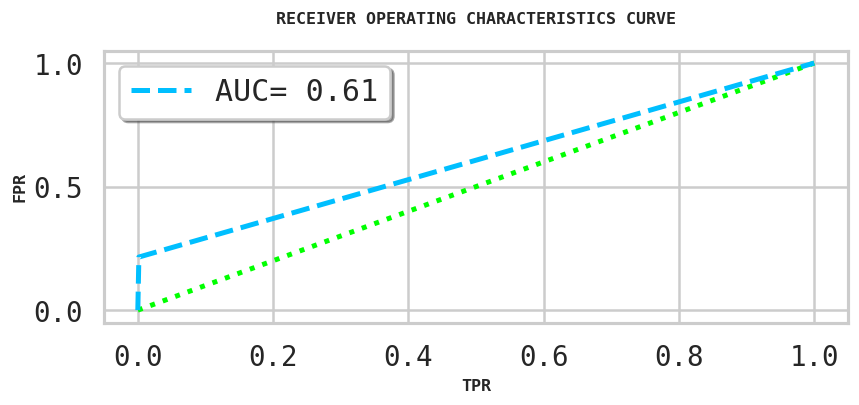





	____________________________________________CONFUSION MATRIX___________________________________________



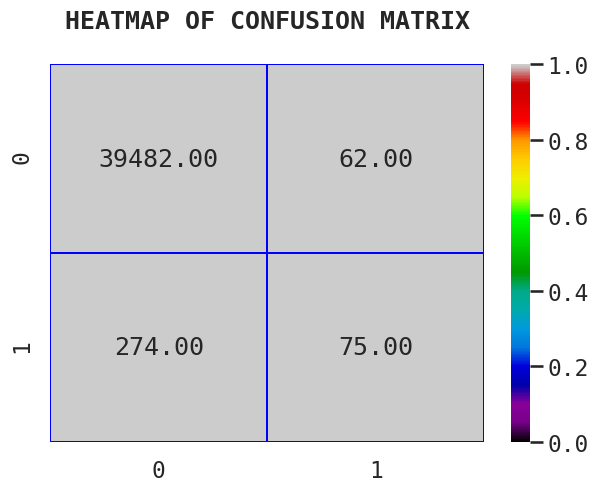



Processing normal
-------------------------------------
ACCURACY SCORE: 0.9308399969919535

F1 score: 0.9616363307701935

CLASSIFICATION REPORT:
               precision    recall  f1-score   support

           0       0.66      0.64      0.65      4013
           1       0.96      0.96      0.96     35880

    accuracy                           0.93     39893
   macro avg       0.81      0.80      0.81     39893
weighted avg       0.93      0.93      0.93     39893


PRECISION:
 0.9595415822626745

RECALL:
 0.9637402452619844

MEAN SQUARED ERROR:
 0.06916000300804652

ROOT MEAN SQ. ERROR:
 0.2629828948963155

LOG_LOSS: 2.3887311028654605

AUC_ROC Score:
 0.8002105163514008

TPR: [0.         0.36331921 1.        ] 
FPR: [0.         0.96374025 1.        ]




	____________________________________________ROC_AUC CURVE_______________________________________________



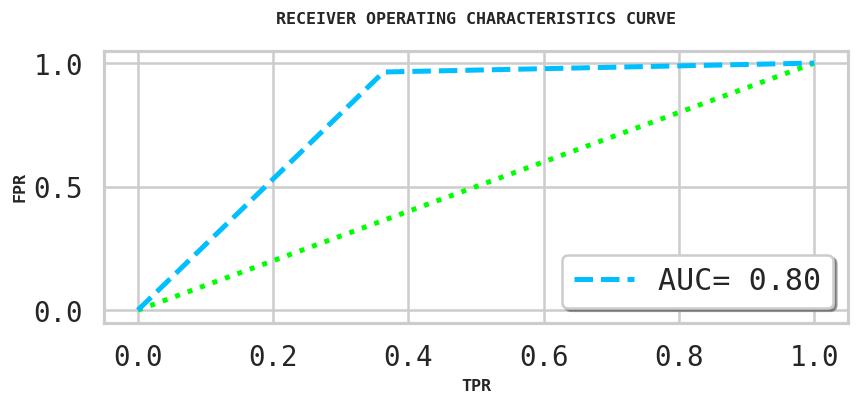





	____________________________________________CONFUSION MATRIX___________________________________________



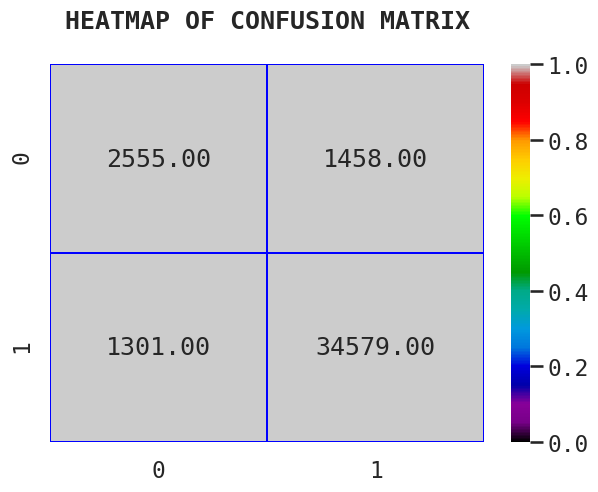

In [68]:
pac_pipeline = Pipeline([('clf', OneVsRestClassifier(PassiveAggressiveClassifier(), n_jobs=1))])
F1=[]
ACCURACY = []
PRECESION = []
RECALL = []
RMSE = []
MSE = []
AUC=[]
TPR=[]
FPR=[]
CV_ACC=[]
LOG_LOSS=[]
for category in labels:
    print('Processing {}'.format(category),'\n-------------------------------------')
    pac_pipeline.fit(x_train, y_train[category])
    pred = pac_pipeline.predict(x_test)
    f1=f1_score(pred,y_test[category])
    acc=accuracy_score(pred,y_test[category])
    clr=classification_report(y_test[category],pred)
    pre=precision_score(y_test[category],pred)
    rec=recall_score(y_test[category],pred)
    mse=mean_squared_error(y_test[category],pred)
    rmse=np.sqrt(mse)
    log = log_loss( y_test[category],pred)
    auc_scr=roc_auc_score(y_test[category],pred)
    tpr,fpr,threshold=roc_curve(y_test[category],pred)
    conf=confusion_matrix(y_test[category],pred)
    print('ACCURACY SCORE:', acc)
    print('\nF1 score:',f1)
    print('\nCLASSIFICATION REPORT:\n',clr)
    print('\nPRECISION:\n',pre)
    print('\nRECALL:\n',rec)
    print('\nMEAN SQUARED ERROR:\n',mse)
    print('\nROOT MEAN SQ. ERROR:\n',rmse)
    print('\nLOG_LOSS:',log)
    print('\nAUC_ROC Score:\n',auc_scr)
    print('\nTPR:',tpr,'\nFPR:',fpr)
        
    print('\n\n\n\t____________________________________________ROC_AUC CURVE_______________________________________________')
   
    sns.set(context='talk',style='whitegrid',palette='dark',font='monospace',font_scale=1)
    plt.figure(figsize=(8,3),dpi=120)
    plt.plot([0,1],[0,1],color='lime',linestyle=":",lw=3)
    plt.plot(tpr,fpr,label="AUC= %0.2f" % auc_scr,color='deepskyblue',lw=3,linestyle='--')
    plt.legend(fancybox=True,shadow=True, fontsize='medium')
    
    plt.xlabel("TPR",weight='bold',fontsize=10)
    plt.ylabel('FPR',weight='bold',fontsize=10)
    plt.title('RECEIVER OPERATING CHARACTERISTICS CURVE\n',size=10,weight='bold',loc='center')
    plt.show()
    
    print('\n\n\n\t____________________________________________CONFUSION MATRIX___________________________________________\n')
    sns.set(context='talk',style='whitegrid',palette='dark',font='monospace',font_scale=1)
    plt.figure(figsize=(7,5),dpi=100)
    sns.heatmap(conf,annot=True,fmt='.2f',vmax=1,vmin=0,cmap='nipy_spectral',linewidths=0.8, linecolor='blue')
    plt.title('HEATMAP OF CONFUSION MATRIX\n',size=18,weight='bold',loc='center')
    plt.show()
    print('\n')
    
    ACCURACY.append(acc)
    F1.append(f1)
    PRECESION.append(pre)
    RECALL.append(rec)
    RMSE.append(rmse)
    MSE.append(mse)
    AUC.append(auc_scr)
    TPR.append(tpr)
    FPR.append(fpr)
    LOG_LOSS.append(log)

pac_results = pd.DataFrame({"LABELS":labels,"F1":F1,'Acuracy':ACCURACY,'Precision': PRECESION ,'Recall': RECALL,
                               'RMSE':RMSE,'MSE':MSE,'AUC':AUC,'LOG_LOSS':LOG_LOSS})
pac_results.style.set_properties(**{'background-color':'black','color': 'lime','border-color': 'darkorange'})   

Processing malignant
-------------------------------------
ACCURACY SCORE: 0.9456796931792545

F1 score: 0.6101816873538406

CLASSIFICATION REPORT:
               precision    recall  f1-score   support

           0       0.95      1.00      0.97     36121
           1       0.95      0.45      0.61      3772

    accuracy                           0.95     39893
   macro avg       0.95      0.72      0.79     39893
weighted avg       0.95      0.95      0.94     39893


PRECISION:
 0.949076664801343

RECALL:
 0.4496288441145281

MEAN SQUARED ERROR:
 0.05432030682074549

ROOT MEAN SQ. ERROR:
 0.23306717233610033

LOG_LOSS: 1.8761587549479262

AUC_ROC Score:
 0.7235547670089543

TPR: [0.         0.00251931 1.        ] 
FPR: [0.         0.44962884 1.        ]




	____________________________________________ROC_AUC CURVE_______________________________________________



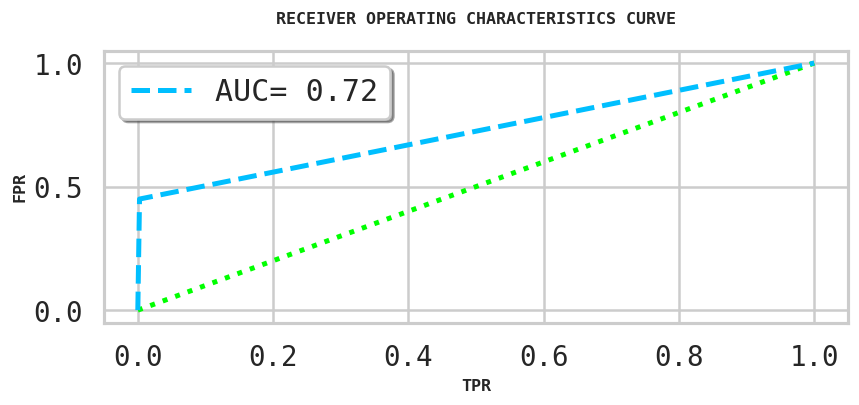





	____________________________________________CONFUSION MATRIX___________________________________________



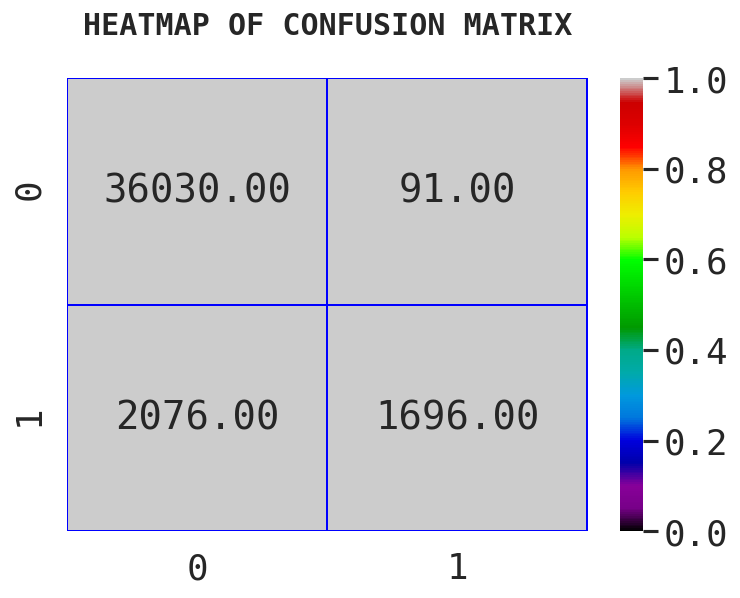



Processing highly_malignant
-------------------------------------
ACCURACY SCORE: 0.9901235805780463

F1 score: 0.3253424657534246

CLASSIFICATION REPORT:
               precision    recall  f1-score   support

           0       0.99      1.00      1.00     39532
           1       0.43      0.26      0.33       361

    accuracy                           0.99     39893
   macro avg       0.71      0.63      0.66     39893
weighted avg       0.99      0.99      0.99     39893


PRECISION:
 0.4260089686098655

RECALL:
 0.2631578947368421

MEAN SQUARED ERROR:
 0.009876419421953726

ROOT MEAN SQ. ERROR:
 0.09938017620206621

LOG_LOSS: 0.3411220075719026

AUC_ROC Score:
 0.6299600057515031

TPR: [0.         0.00323788 1.        ] 
FPR: [0.         0.26315789 1.        ]




	____________________________________________ROC_AUC CURVE_______________________________________________



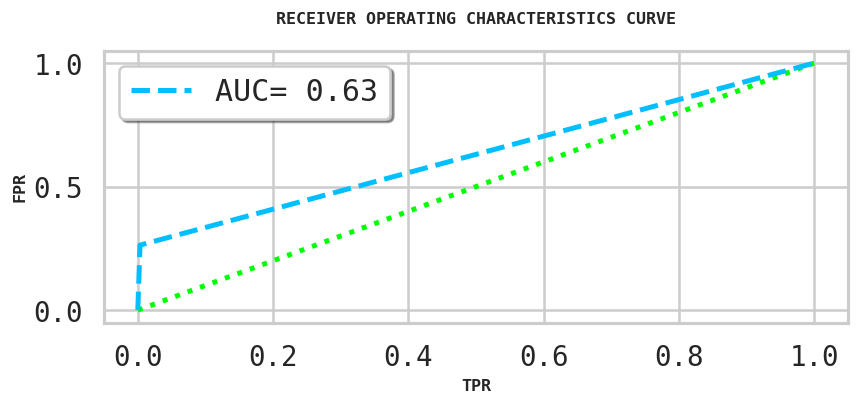





	____________________________________________CONFUSION MATRIX___________________________________________



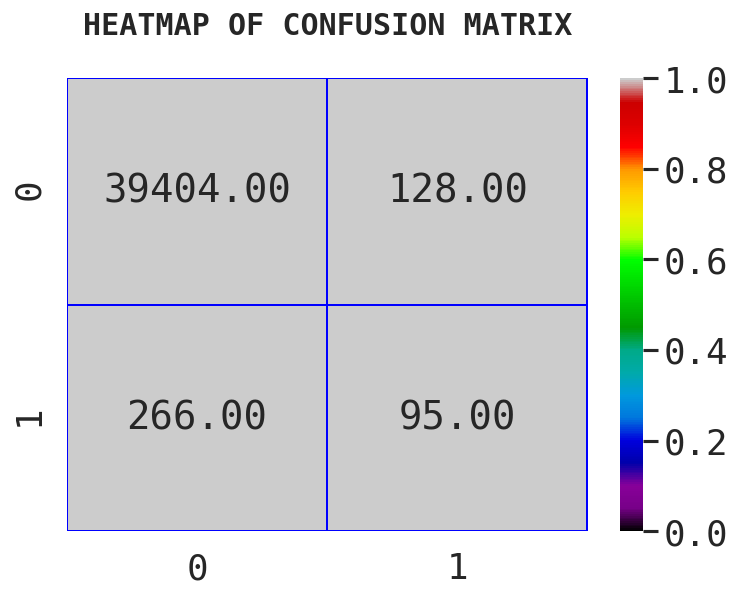



Processing rude
-------------------------------------
ACCURACY SCORE: 0.9723510390294037

F1 score: 0.6617601962588163

CLASSIFICATION REPORT:
               precision    recall  f1-score   support

           0       0.97      1.00      0.99     37832
           1       0.90      0.52      0.66      2061

    accuracy                           0.97     39893
   macro avg       0.94      0.76      0.82     39893
weighted avg       0.97      0.97      0.97     39893


PRECISION:
 0.8991666666666667

RECALL:
 0.5235322658903445

MEAN SQUARED ERROR:
 0.027648960970596347

ROOT MEAN SQ. ERROR:
 0.1662797671714642

LOG_LOSS: 0.9549637057848637

AUC_ROC Score:
 0.7601669576438401

TPR: [0.         0.00319835 1.        ] 
FPR: [0.         0.52353227 1.        ]




	____________________________________________ROC_AUC CURVE_______________________________________________



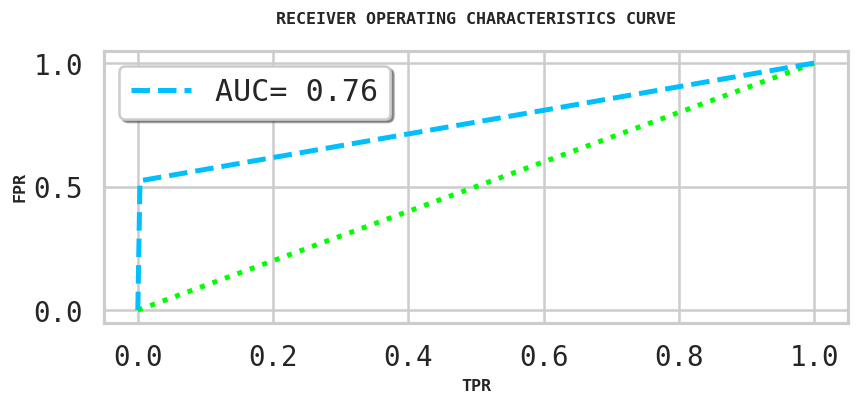





	____________________________________________CONFUSION MATRIX___________________________________________



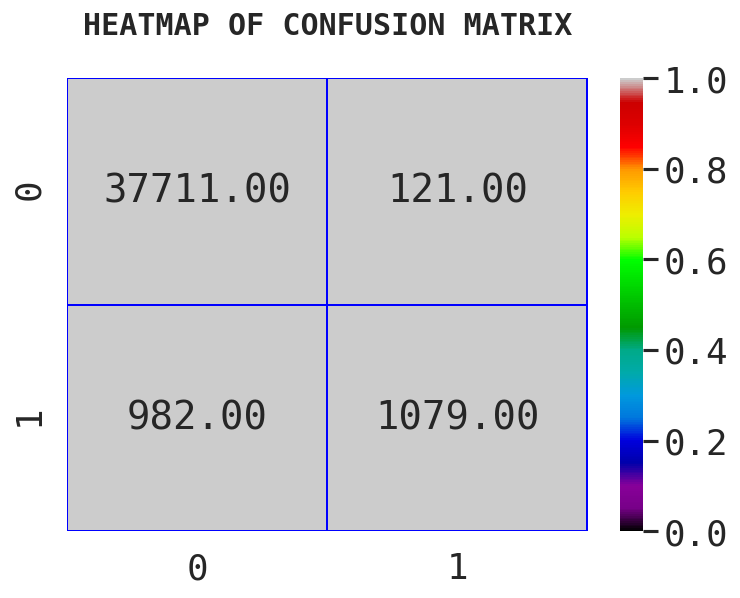



Processing threat
-------------------------------------
ACCURACY SCORE: 0.997217556964881

F1 score: 0.017699115044247784

CLASSIFICATION REPORT:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     39786
           1       0.17      0.01      0.02       107

    accuracy                           1.00     39893
   macro avg       0.58      0.50      0.51     39893
weighted avg       1.00      1.00      1.00     39893


PRECISION:
 0.16666666666666666

RECALL:
 0.009345794392523364

MEAN SQUARED ERROR:
 0.0027824430351189432

ROOT MEAN SQ. ERROR:
 0.05274886761930481

LOG_LOSS: 0.09610227803931207

AUC_ROC Score:
 0.5046100610227333

TPR: [0.00000000e+00 1.25672347e-04 1.00000000e+00] 
FPR: [0.         0.00934579 1.        ]




	____________________________________________ROC_AUC CURVE_______________________________________________



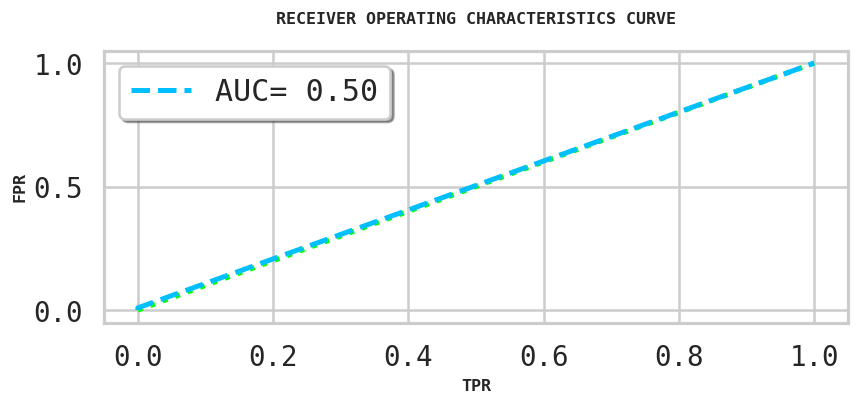





	____________________________________________CONFUSION MATRIX___________________________________________



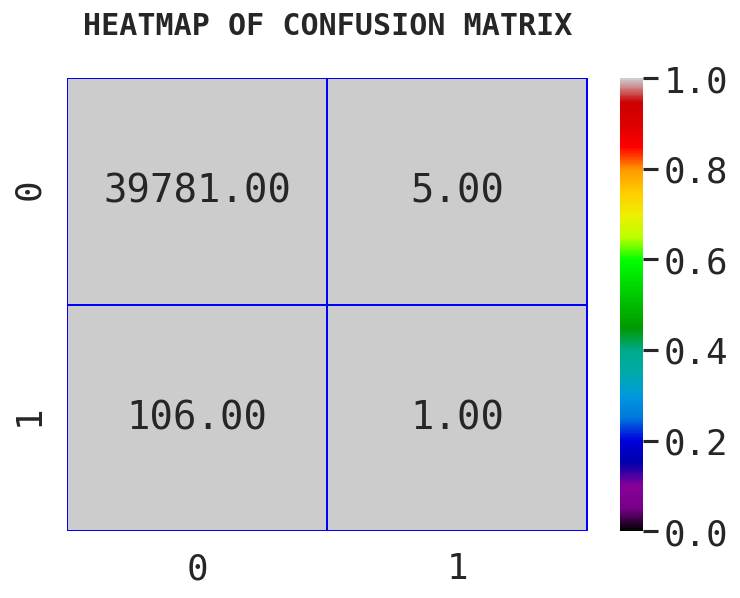



Processing abuse
-------------------------------------
ACCURACY SCORE: 0.9654325320231619

F1 score: 0.536158762193071

CLASSIFICATION REPORT:
               precision    recall  f1-score   support

           0       0.97      0.99      0.98     37916
           1       0.80      0.40      0.54      1977

    accuracy                           0.97     39893
   macro avg       0.88      0.70      0.76     39893
weighted avg       0.96      0.97      0.96     39893


PRECISION:
 0.8002008032128514

RECALL:
 0.4031360647445625

MEAN SQUARED ERROR:
 0.03456746797683804

ROOT MEAN SQ. ERROR:
 0.18592328519267842

LOG_LOSS: 1.1939220356571447

AUC_ROC Score:
 0.698943810407939

TPR: [0.         0.00524844 1.        ] 
FPR: [0.         0.40313606 1.        ]




	____________________________________________ROC_AUC CURVE_______________________________________________



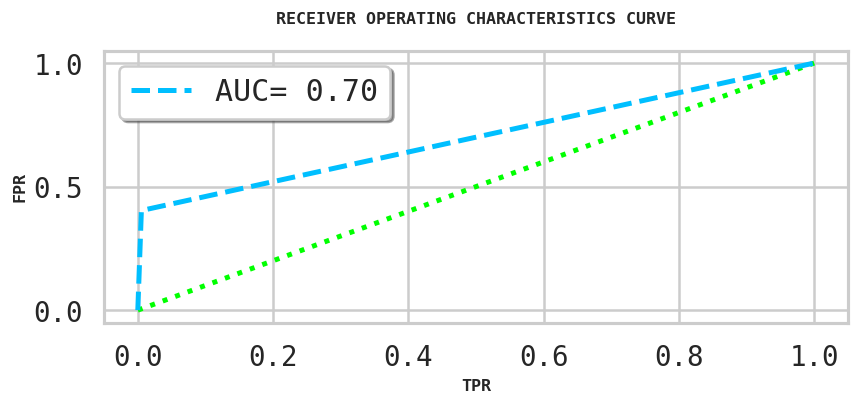





	____________________________________________CONFUSION MATRIX___________________________________________



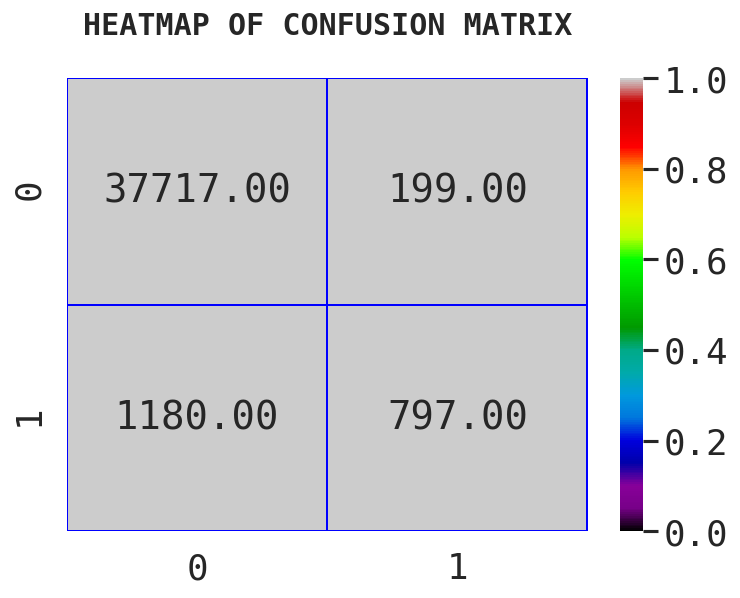



Processing loathe
-------------------------------------
ACCURACY SCORE: 0.9916526708946432

F1 score: 0.23094688221709003

CLASSIFICATION REPORT:
               precision    recall  f1-score   support

           0       0.99      1.00      1.00     39544
           1       0.60      0.14      0.23       349

    accuracy                           0.99     39893
   macro avg       0.79      0.57      0.61     39893
weighted avg       0.99      0.99      0.99     39893


PRECISION:
 0.5952380952380952

RECALL:
 0.14326647564469913

MEAN SQUARED ERROR:
 0.00834732910535683

ROOT MEAN SQ. ERROR:
 0.09136371875836069

LOG_LOSS: 0.2883072149454271

AUC_ROC Score:
 0.5712033369524325

TPR: [0.0000000e+00 8.5980174e-04 1.0000000e+00] 
FPR: [0.         0.14326648 1.        ]




	____________________________________________ROC_AUC CURVE_______________________________________________



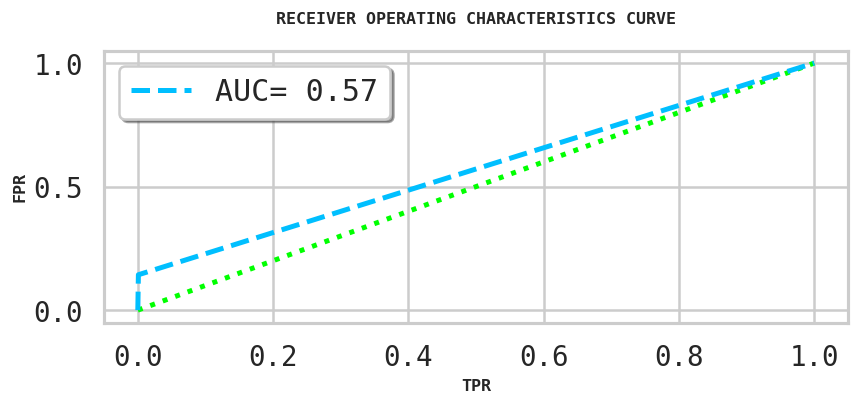





	____________________________________________CONFUSION MATRIX___________________________________________



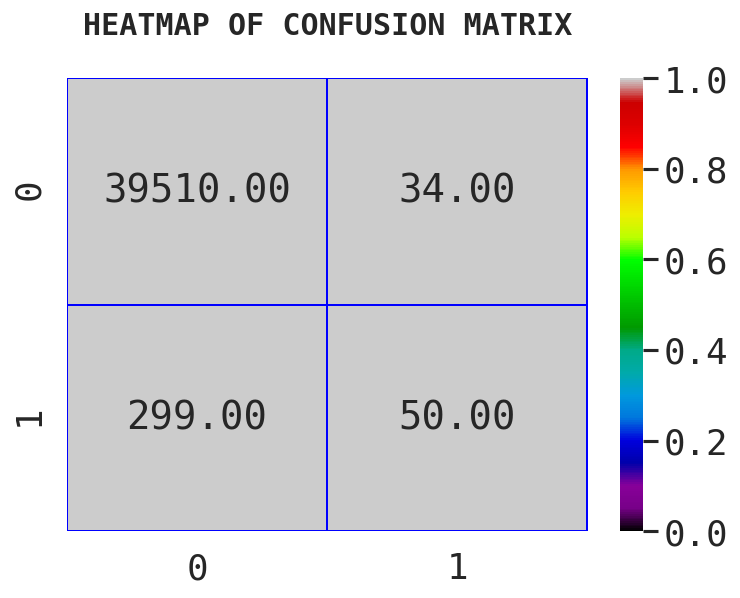



Processing normal
-------------------------------------
ACCURACY SCORE: 0.9429473842528765

F1 score: 0.9691966219142486

CLASSIFICATION REPORT:
               precision    recall  f1-score   support

           0       0.96      0.45      0.61      4013
           1       0.94      1.00      0.97     35880

    accuracy                           0.94     39893
   macro avg       0.95      0.72      0.79     39893
weighted avg       0.94      0.94      0.93     39893


PRECISION:
 0.9420648284571669

RECALL:
 0.9979375696767001

MEAN SQUARED ERROR:
 0.05705261574712356

ROOT MEAN SQ. ERROR:
 0.23885689386560222

LOG_LOSS: 1.9705716739367314

AUC_ROC Score:
 0.7246104494284322

TPR: [0.         0.54871667 1.        ] 
FPR: [0.         0.99793757 1.        ]




	____________________________________________ROC_AUC CURVE_______________________________________________



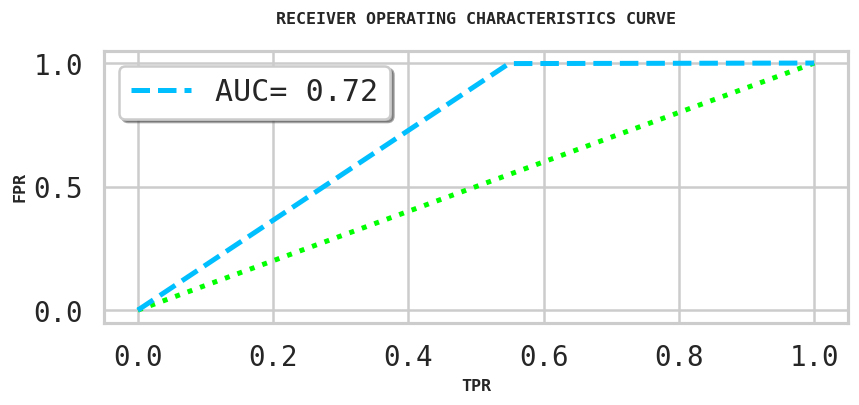





	____________________________________________CONFUSION MATRIX___________________________________________



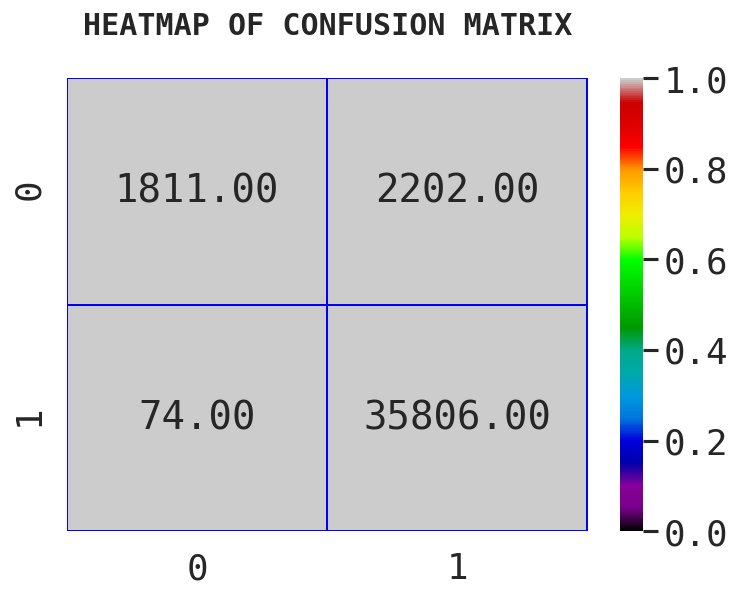

In [69]:
MNB_pipeline = Pipeline([('clf', OneVsRestClassifier(MultinomialNB(fit_prior=True, class_prior=None), n_jobs=-1))])
F1=[]
ACCURACY = []
PRECESION = []
RECALL = []
RMSE = []
MSE = []
AUC=[]
TPR=[]
FPR=[]
CV_ACC=[]
LOG_LOSS=[]
for category in labels:
    print('Processing {}'.format(category))
    print('-------------------------------------')
    MNB_pipeline.fit(x_train, y_train[category])
    pred = MNB_pipeline.predict(x_test)
    f1=f1_score(pred,y_test[category])
    acc=accuracy_score(pred,y_test[category])
    clr=classification_report(y_test[category],pred)
    pre=precision_score(y_test[category],pred)
    rec=recall_score(y_test[category],pred)
    mse=mean_squared_error(y_test[category],pred)
    rmse=np.sqrt(mse)
    log = log_loss( y_test[category],pred)
    auc_scr=roc_auc_score(y_test[category],pred)
    tpr,fpr,threshold=roc_curve(y_test[category],pred)
    conf=confusion_matrix(y_test[category],pred)
    
    print('ACCURACY SCORE:', acc)
    print('\nF1 score:',f1)
    print('\nCLASSIFICATION REPORT:\n',clr)
    print('\nPRECISION:\n',pre)
    print('\nRECALL:\n',rec)
    print('\nMEAN SQUARED ERROR:\n',mse)
    print('\nROOT MEAN SQ. ERROR:\n',rmse)
    print('\nLOG_LOSS:',log)
    print('\nAUC_ROC Score:\n',auc_scr)
    print('\nTPR:',tpr,'\nFPR:',fpr)
    
    print('\n\n\n\t____________________________________________ROC_AUC CURVE_______________________________________________')
    print()
    sns.set(context='talk',style='whitegrid',palette='dark',font='monospace',font_scale=1)
    plt.figure(figsize=(8,3),dpi=120)
    plt.plot([0,1],[0,1],color='lime',linestyle=":",lw=3)
    plt.plot(tpr,fpr,label="AUC= %0.2f" % auc_scr,color='deepskyblue',lw=3,linestyle='--')
    plt.legend(fancybox=True,shadow=True, fontsize='medium')
    
    plt.xlabel("TPR",weight='bold',fontsize=10)
    plt.ylabel('FPR',weight='bold',fontsize=10)
    plt.title('RECEIVER OPERATING CHARACTERISTICS CURVE\n',size=10,weight='bold',loc='center')
    plt.show()
    
    print('\n\n\n\t____________________________________________CONFUSION MATRIX___________________________________________\n')
    sns.set(context='talk',style='whitegrid',palette='dark',font='monospace',font_scale=1.3)
    plt.figure(figsize=(7,5),dpi=120)
    sns.heatmap(conf,annot=True,fmt='.2f',vmax=1,vmin=0,cmap='nipy_spectral',linewidths=0.8, linecolor='blue')
    plt.title('HEATMAP OF CONFUSION MATRIX\n',size=18,weight='bold',loc='center')
    plt.show()
    print('\n')
    
    ACCURACY.append(acc)
    F1.append(f1)
    PRECESION.append(pre)
    RECALL.append(rec)
    RMSE.append(rmse)
    MSE.append(mse)
    AUC.append(auc_scr)
    TPR.append(tpr)
    FPR.append(fpr)
    LOG_LOSS.append(log)

mnb_results = pd.DataFrame({"LABELS":labels,"F1":F1,'Acuracy':ACCURACY,'Precision': PRECESION ,'Recall': RECALL,
                               'RMSE':RMSE,'MSE':MSE,'AUC':AUC,'LOG_LOSS':LOG_LOSS})
mnb_results.style.set_properties(**{'background-color':'black','color': 'lime','border-color': 'darkorange'})


Processing malignant
-------------------------------------
ACCURACY SCORE: 0.8719324192214173

F1 score: 0.539106901217862

CLASSIFICATION REPORT:
               precision    recall  f1-score   support

           0       0.98      0.88      0.93     36121
           1       0.41      0.79      0.54      3772

    accuracy                           0.87     39893
   macro avg       0.69      0.84      0.73     39893
weighted avg       0.92      0.87      0.89     39893


PRECISION:
 0.4085874470121701

RECALL:
 0.792152704135737

MEAN SQUARED ERROR:
 0.1280675807785827

ROOT MEAN SQ. ERROR:
 0.3578653109461473

LOG_LOSS: 4.423384224312143

AUC_ROC Score:
 0.8362081313652302

TPR: [0.         0.11973644 1.        ] 
FPR: [0.        0.7921527 1.       ]




	____________________________________________ROC_AUC CURVE_______________________________________________



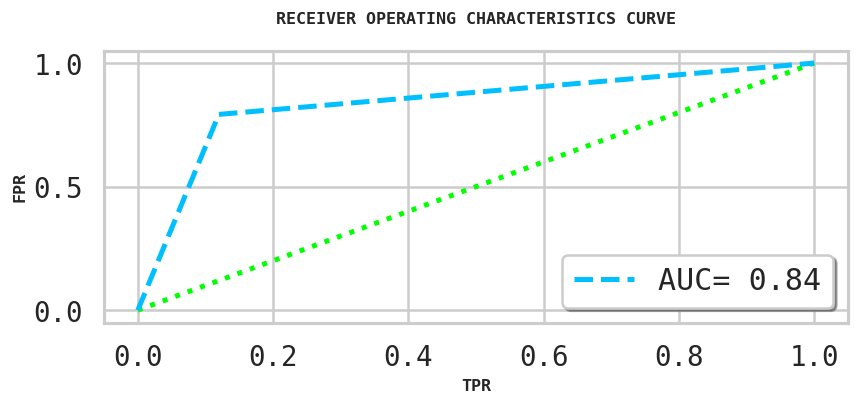





	____________________________________________CONFUSION MATRIX___________________________________________



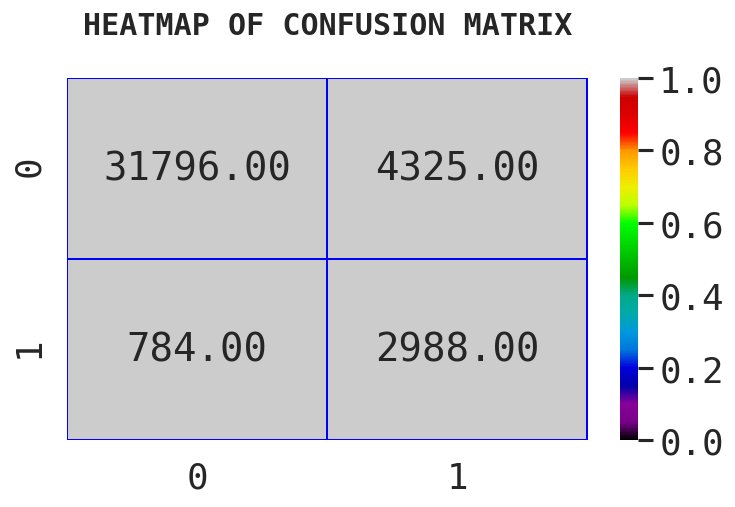



Processing highly_malignant
-------------------------------------
ACCURACY SCORE: 0.9229689419196351

F1 score: 0.17724230254350737

CLASSIFICATION REPORT:
               precision    recall  f1-score   support

           0       1.00      0.92      0.96     39532
           1       0.10      0.92      0.18       361

    accuracy                           0.92     39893
   macro avg       0.55      0.92      0.57     39893
weighted avg       0.99      0.92      0.95     39893


PRECISION:
 0.0981031416716064

RECALL:
 0.9168975069252078

MEAN SQUARED ERROR:
 0.07703105808036498

ROOT MEAN SQ. ERROR:
 0.2775446956444403

LOG_LOSS: 2.6606194830306227

AUC_ROC Score:
 0.9199609461166562

TPR: [0.         0.07697561 1.        ] 
FPR: [0.         0.91689751 1.        ]




	____________________________________________ROC_AUC CURVE_______________________________________________



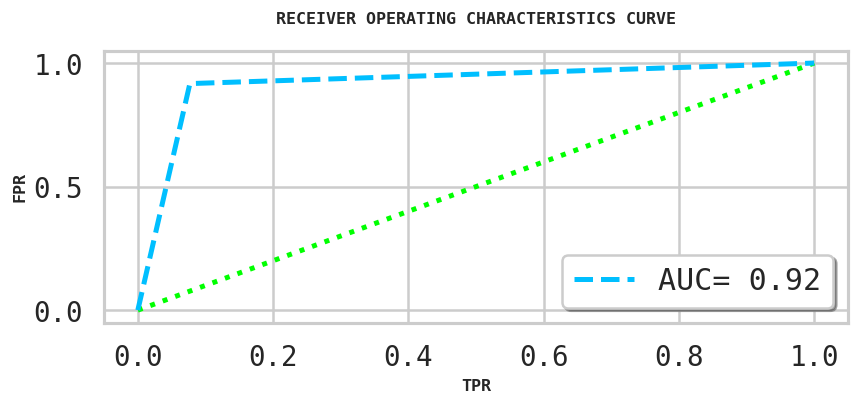





	____________________________________________CONFUSION MATRIX___________________________________________



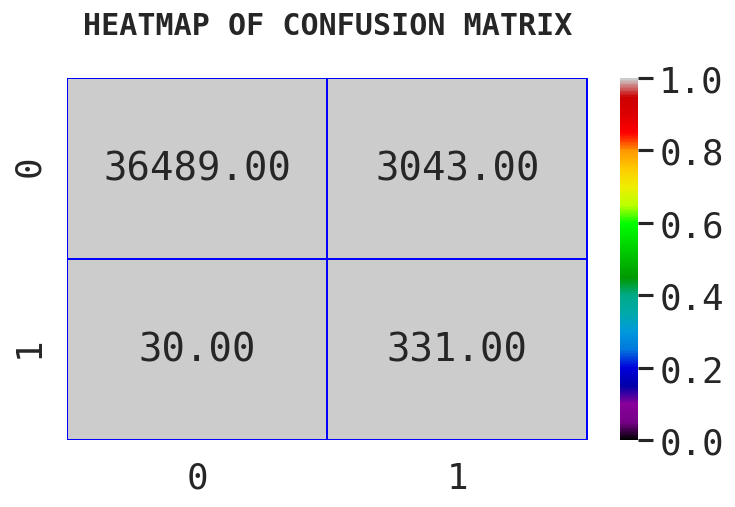



Processing rude
-------------------------------------
ACCURACY SCORE: 0.9042689193592861

F1 score: 0.47891936144085134

CLASSIFICATION REPORT:
               precision    recall  f1-score   support

           0       0.99      0.91      0.95     37832
           1       0.33      0.85      0.48      2061

    accuracy                           0.90     39893
   macro avg       0.66      0.88      0.71     39893
weighted avg       0.96      0.90      0.92     39893


PRECISION:
 0.3331435079726651

RECALL:
 0.851528384279476

MEAN SQUARED ERROR:
 0.09573108064071391

ROOT MEAN SQ. ERROR:
 0.309404396608571

LOG_LOSS: 3.306504801291861

AUC_ROC Score:
 0.8793352431018864

TPR: [0.        0.0928579 1.       ] 
FPR: [0.         0.85152838 1.        ]




	____________________________________________ROC_AUC CURVE_______________________________________________



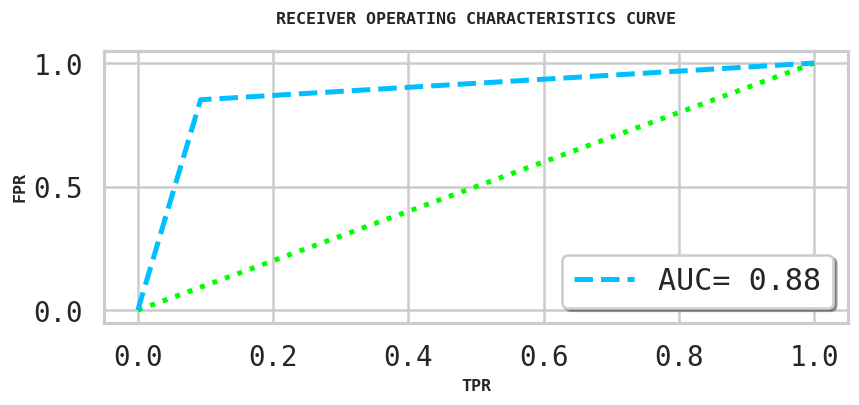





	____________________________________________CONFUSION MATRIX___________________________________________



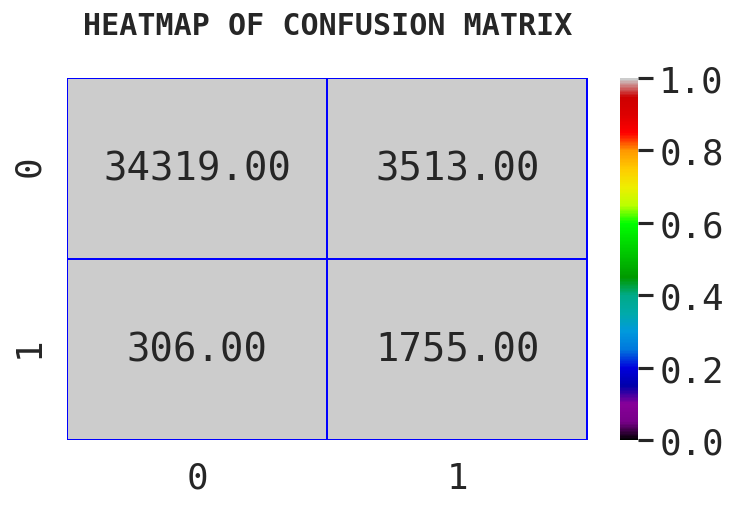



Processing threat
-------------------------------------
ACCURACY SCORE: 0.878224249868398

F1 score: 0.03801980198019802

CLASSIFICATION REPORT:
               precision    recall  f1-score   support

           0       1.00      0.88      0.93     39786
           1       0.02      0.90      0.04       107

    accuracy                           0.88     39893
   macro avg       0.51      0.89      0.49     39893
weighted avg       1.00      0.88      0.93     39893


PRECISION:
 0.019421404005664576

RECALL:
 0.897196261682243

MEAN SQUARED ERROR:
 0.12177575013160204

ROOT MEAN SQ. ERROR:
 0.3489638235284598

LOG_LOSS: 4.206082555215709

AUC_ROC Score:
 0.887684744222713

TPR: [0.         0.12182677 1.        ] 
FPR: [0.         0.89719626 1.        ]




	____________________________________________ROC_AUC CURVE_______________________________________________



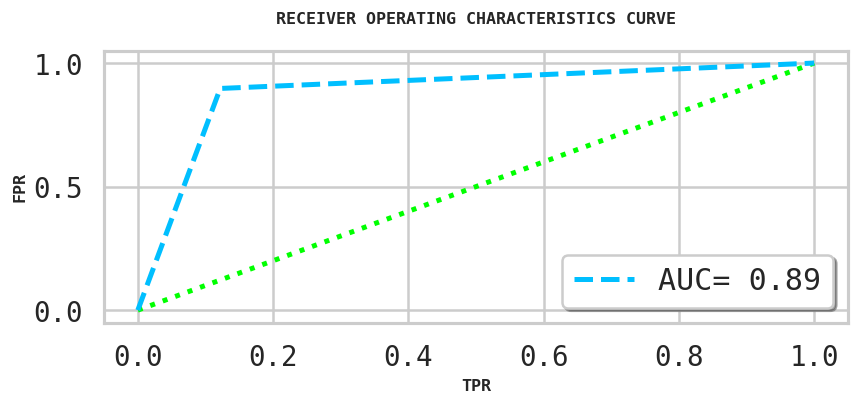





	____________________________________________CONFUSION MATRIX___________________________________________



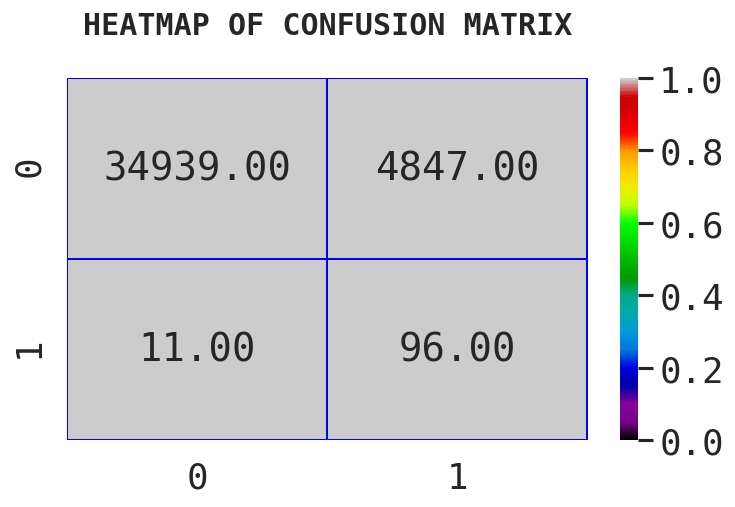



Processing abuse
-------------------------------------
ACCURACY SCORE: 0.8941668964479984

F1 score: 0.43435155412647375

CLASSIFICATION REPORT:
               precision    recall  f1-score   support

           0       0.99      0.90      0.94     37916
           1       0.30      0.82      0.43      1977

    accuracy                           0.89     39893
   macro avg       0.64      0.86      0.69     39893
weighted avg       0.96      0.89      0.92     39893


PRECISION:
 0.29542555130308

RECALL:
 0.8199291856348002

MEAN SQUARED ERROR:
 0.10583310355200161

ROOT MEAN SQ. ERROR:
 0.32532000177056686

LOG_LOSS: 3.6554233871350372

AUC_ROC Score:
 0.8589834766659072

TPR: [0.         0.10196223 1.        ] 
FPR: [0.         0.81992919 1.        ]




	____________________________________________ROC_AUC CURVE_______________________________________________



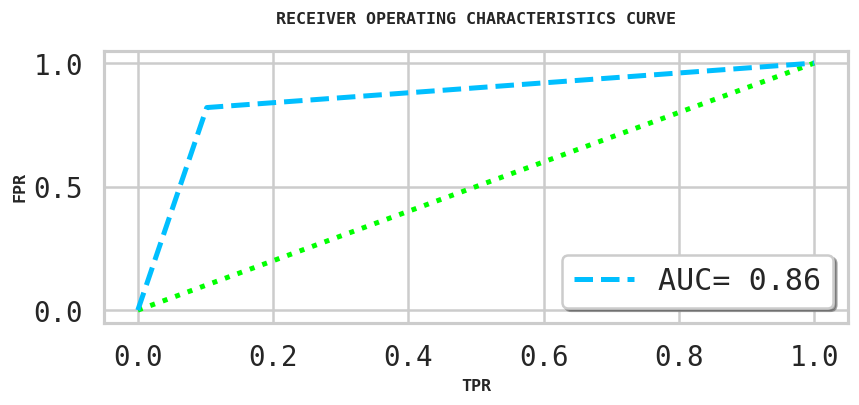





	____________________________________________CONFUSION MATRIX___________________________________________



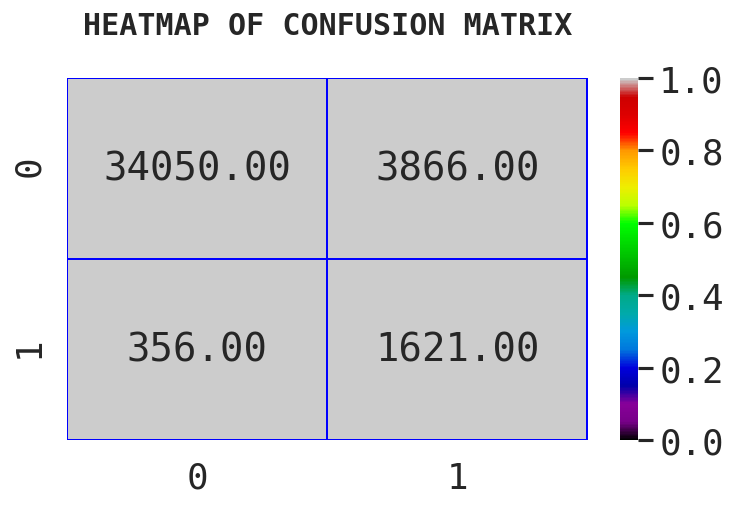



Processing loathe
-------------------------------------
ACCURACY SCORE: 0.8934148848168851

F1 score: 0.12402142562834777

CLASSIFICATION REPORT:
               precision    recall  f1-score   support

           0       1.00      0.89      0.94     39544
           1       0.07      0.86      0.12       349

    accuracy                           0.89     39893
   macro avg       0.53      0.88      0.53     39893
weighted avg       0.99      0.89      0.94     39893


PRECISION:
 0.06681465038845727

RECALL:
 0.8624641833810889

MEAN SQUARED ERROR:
 0.10658511518311484

ROOT MEAN SQ. ERROR:
 0.32647375879711193

LOG_LOSS: 3.681403723429093

AUC_ROC Score:
 0.878076113539624

TPR: [0.         0.10631196 1.        ] 
FPR: [0.         0.86246418 1.        ]




	____________________________________________ROC_AUC CURVE_______________________________________________



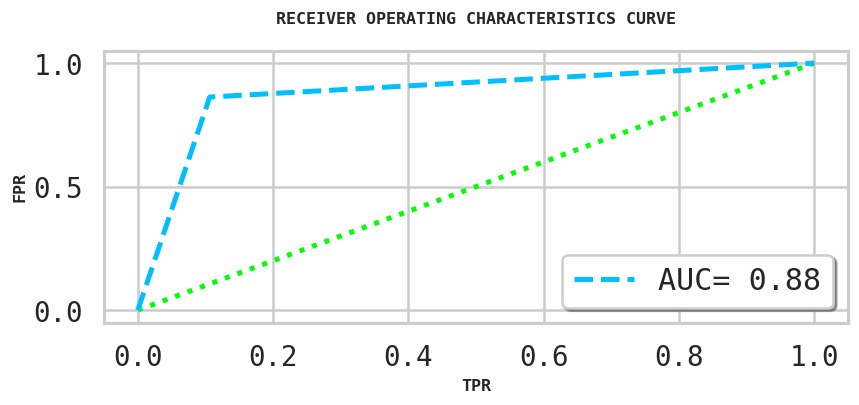





	____________________________________________CONFUSION MATRIX___________________________________________



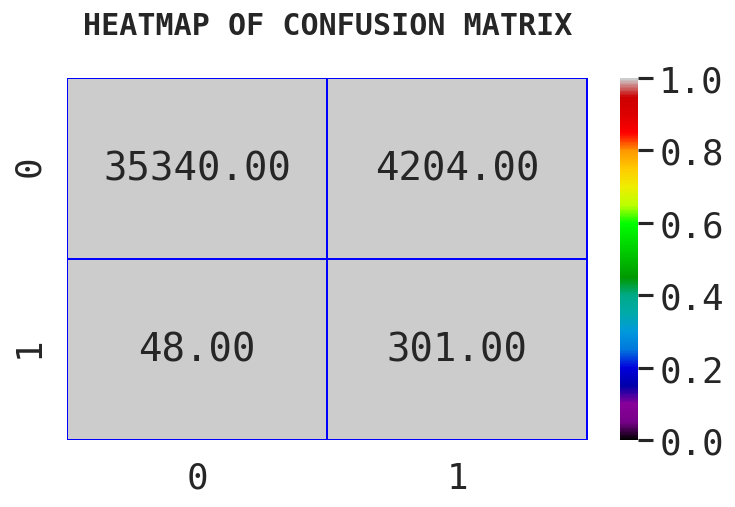



Processing normal
-------------------------------------
ACCURACY SCORE: 0.8502494171909859

F1 score: 0.9110137933089046

CLASSIFICATION REPORT:
               precision    recall  f1-score   support

           0       0.39      0.83      0.53      4013
           1       0.98      0.85      0.91     35880

    accuracy                           0.85     39893
   macro avg       0.68      0.84      0.72     39893
weighted avg       0.92      0.85      0.87     39893


PRECISION:
 0.9784347603506751

RECALL:
 0.8522853957636566

MEAN SQUARED ERROR:
 0.1497505828090141

ROOT MEAN SQ. ERROR:
 0.3869762044480437

LOG_LOSS: 5.1722154040023165

AUC_ROC Score:
 0.8421656233739788

TPR: [0.         0.16795415 1.        ] 
FPR: [0.        0.8522854 1.       ]




	____________________________________________ROC_AUC CURVE_______________________________________________



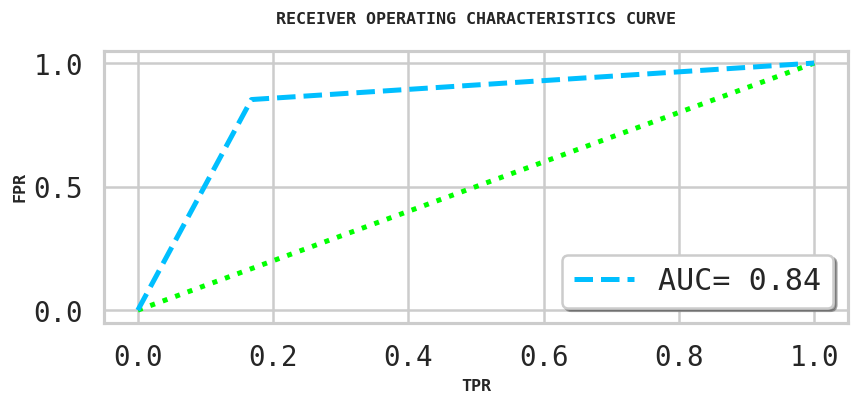





	____________________________________________CONFUSION MATRIX___________________________________________



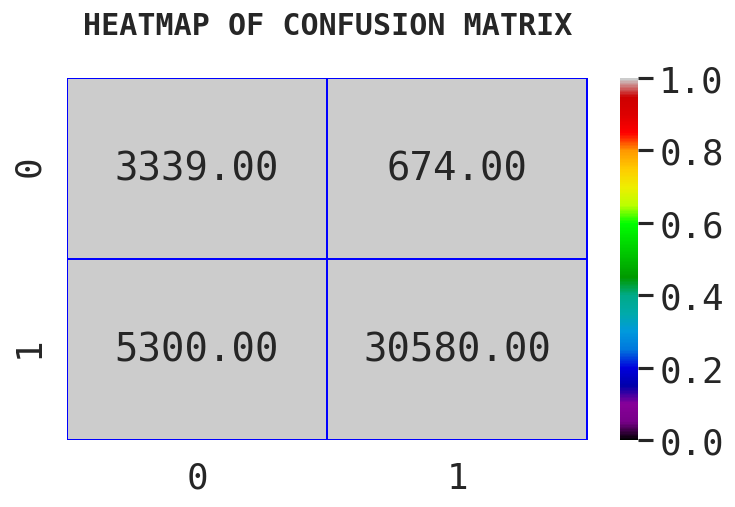

In [70]:
CNB_pipeline = Pipeline([('clf', OneVsRestClassifier(ComplementNB(fit_prior=True, class_prior=None), n_jobs=-1))])
F1=[]
ACCURACY = []
PRECESION = []
RECALL = []
RMSE = []
MSE = []
AUC=[]
TPR=[]
FPR=[]
CV_ACC=[]
LOG_LOSS=[]
for category in labels:
    print('Processing {}'.format(category),'\n-------------------------------------')
    CNB_pipeline.fit(x_train, y_train[category])
    pred = CNB_pipeline.predict(x_test)
    f1=f1_score(pred,y_test[category])
    acc=accuracy_score(pred,y_test[category])
    clr=classification_report(y_test[category],pred)
    pre=precision_score(y_test[category],pred)
    rec=recall_score(y_test[category],pred)
    mse=mean_squared_error(y_test[category],pred)
    rmse=np.sqrt(mse)
    log = log_loss( y_test[category],pred)
    auc_scr=roc_auc_score(y_test[category],pred)
    tpr,fpr,threshold=roc_curve(y_test[category],pred)
    conf=confusion_matrix(y_test[category],pred)
        

    print('ACCURACY SCORE:', acc)
    print('\nF1 score:',f1)
    print('\nCLASSIFICATION REPORT:\n',clr)
    print('\nPRECISION:\n',pre)
    print('\nRECALL:\n',rec)
    print('\nMEAN SQUARED ERROR:\n',mse)
    print('\nROOT MEAN SQ. ERROR:\n',rmse)
    print('\nLOG_LOSS:',log)
    print('\nAUC_ROC Score:\n',auc_scr)
    print('\nTPR:',tpr,'\nFPR:',fpr)
   
    print('\n\n\n\t____________________________________________ROC_AUC CURVE_______________________________________________')
    
    sns.set(context='talk',style='whitegrid',palette='dark',font='monospace',font_scale=1)
    plt.figure(figsize=(8,3),dpi=120)
    plt.plot([0,1],[0,1],color='lime',linestyle=":",lw=3)
    plt.plot(tpr,fpr,label="AUC= %0.2f" % auc_scr,color='deepskyblue',lw=3,linestyle='--')
    plt.legend(fancybox=True,shadow=True, fontsize='medium')
    
    plt.xlabel("TPR",weight='bold',fontsize=10)
    plt.ylabel('FPR',weight='bold',fontsize=10)
    plt.title('RECEIVER OPERATING CHARACTERISTICS CURVE\n',size=10,weight='bold',loc='center')
    plt.show()

    print('\n\n\n\t____________________________________________CONFUSION MATRIX___________________________________________\n')
    sns.set(context='talk',style='whitegrid',palette='dark',font='monospace',font_scale=1.3)
    plt.figure(figsize=(7,4),dpi=120)
    sns.heatmap(conf,annot=True,fmt='.2f',vmax=1,vmin=0,cmap='nipy_spectral',linewidths=0.8, linecolor='blue')
    plt.title('HEATMAP OF CONFUSION MATRIX\n',size=18,weight='bold',loc='center')
    plt.show()
    print('\n')
    ACCURACY.append(acc)
    F1.append(f1)
    PRECESION.append(pre)
    RECALL.append(rec)
    RMSE.append(rmse)
    MSE.append(mse)
    AUC.append(auc_scr)
    TPR.append(tpr)
    FPR.append(fpr)
    LOG_LOSS.append(log)

cnb_results = pd.DataFrame({"LABELS":labels,"F1":F1,'Acuracy':ACCURACY,'Precision': PRECESION ,'Recall': RECALL,
                               'RMSE':RMSE,'MSE':MSE,'AUC':AUC,'LOG_LOSS':LOG_LOSS})
cnb_results.style.set_properties(**{'background-color':'black','color': 'lime','border-color': 'darkorange'})


Processing malignant
-------------------------------------
ACCURACY SCORE: 0.8719324192214173

F1 score: 0.539106901217862

CLASSIFICATION REPORT:
               precision    recall  f1-score   support

           0       0.98      0.88      0.93     36121
           1       0.41      0.79      0.54      3772

    accuracy                           0.87     39893
   macro avg       0.69      0.84      0.73     39893
weighted avg       0.92      0.87      0.89     39893


PRECISION:
 0.4085874470121701

RECALL:
 0.792152704135737

MEAN SQUARED ERROR:
 0.1280675807785827

ROOT MEAN SQ. ERROR:
 0.3578653109461473

LOG_LOSS: 4.423384224312143

AUC_ROC Score:
 0.8362081313652302

TPR: [0.         0.11973644 1.        ] 
FPR: [0.        0.7921527 1.       ]




	____________________________________________ROC_AUC CURVE_______________________________________________



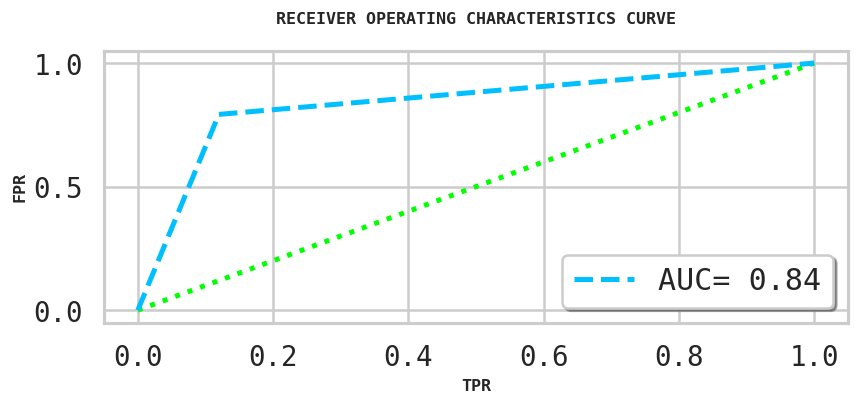





	____________________________________________CONFUSION MATRIX___________________________________________



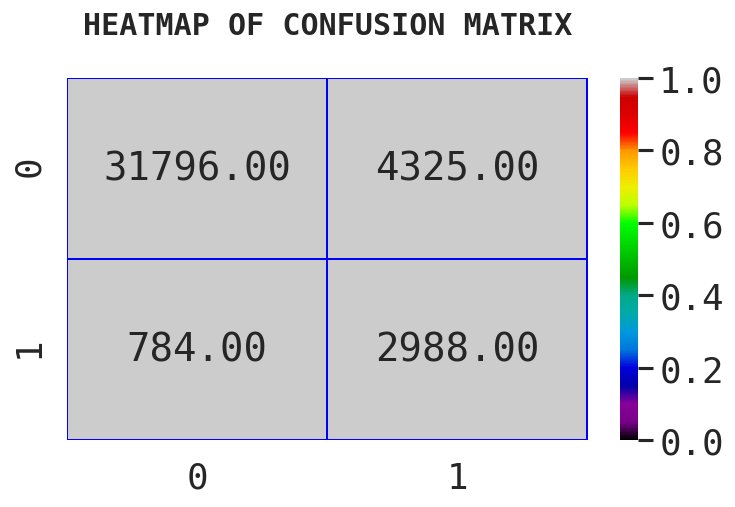



Processing highly_malignant
-------------------------------------
ACCURACY SCORE: 0.9229689419196351

F1 score: 0.17724230254350737

CLASSIFICATION REPORT:
               precision    recall  f1-score   support

           0       1.00      0.92      0.96     39532
           1       0.10      0.92      0.18       361

    accuracy                           0.92     39893
   macro avg       0.55      0.92      0.57     39893
weighted avg       0.99      0.92      0.95     39893


PRECISION:
 0.0981031416716064

RECALL:
 0.9168975069252078

MEAN SQUARED ERROR:
 0.07703105808036498

ROOT MEAN SQ. ERROR:
 0.2775446956444403

LOG_LOSS: 2.6606194830306227

AUC_ROC Score:
 0.9199609461166562

TPR: [0.         0.07697561 1.        ] 
FPR: [0.         0.91689751 1.        ]




	____________________________________________ROC_AUC CURVE_______________________________________________



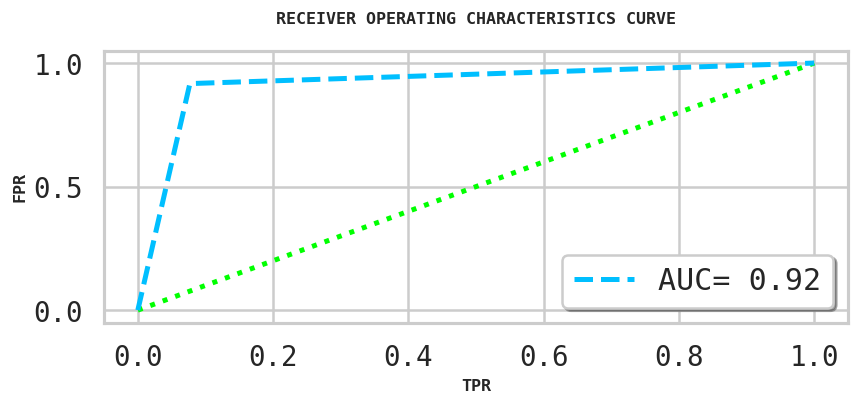





	____________________________________________CONFUSION MATRIX___________________________________________



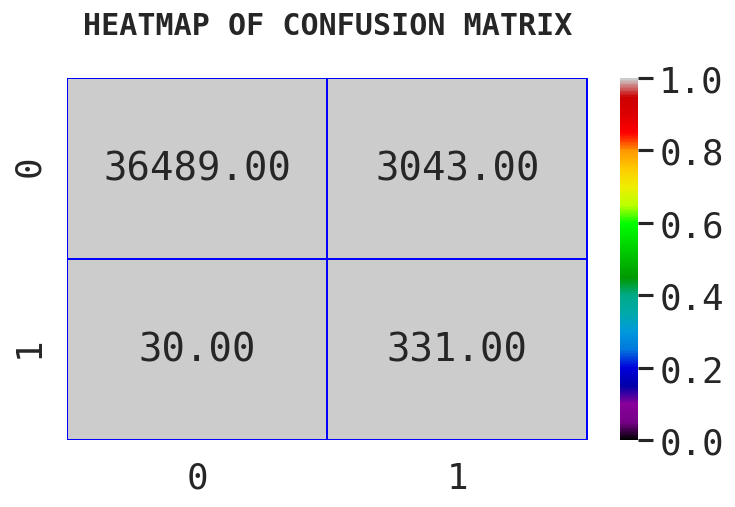



Processing rude
-------------------------------------
ACCURACY SCORE: 0.9042689193592861

F1 score: 0.47891936144085134

CLASSIFICATION REPORT:
               precision    recall  f1-score   support

           0       0.99      0.91      0.95     37832
           1       0.33      0.85      0.48      2061

    accuracy                           0.90     39893
   macro avg       0.66      0.88      0.71     39893
weighted avg       0.96      0.90      0.92     39893


PRECISION:
 0.3331435079726651

RECALL:
 0.851528384279476

MEAN SQUARED ERROR:
 0.09573108064071391

ROOT MEAN SQ. ERROR:
 0.309404396608571

LOG_LOSS: 3.306504801291861

AUC_ROC Score:
 0.8793352431018864

TPR: [0.        0.0928579 1.       ] 
FPR: [0.         0.85152838 1.        ]




	____________________________________________ROC_AUC CURVE_______________________________________________



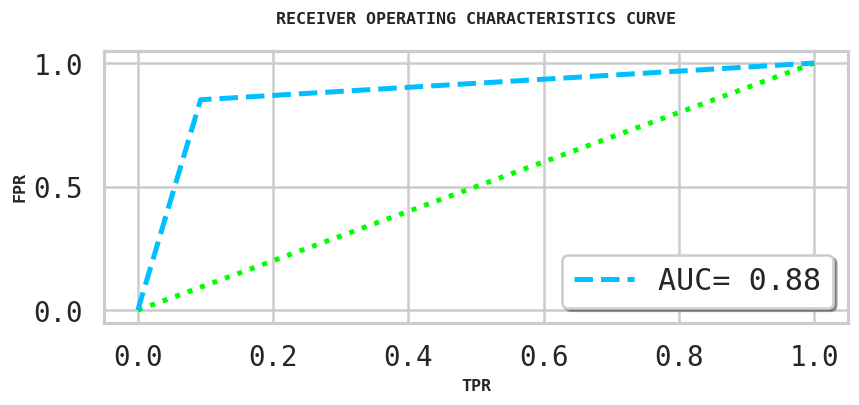





	____________________________________________CONFUSION MATRIX___________________________________________



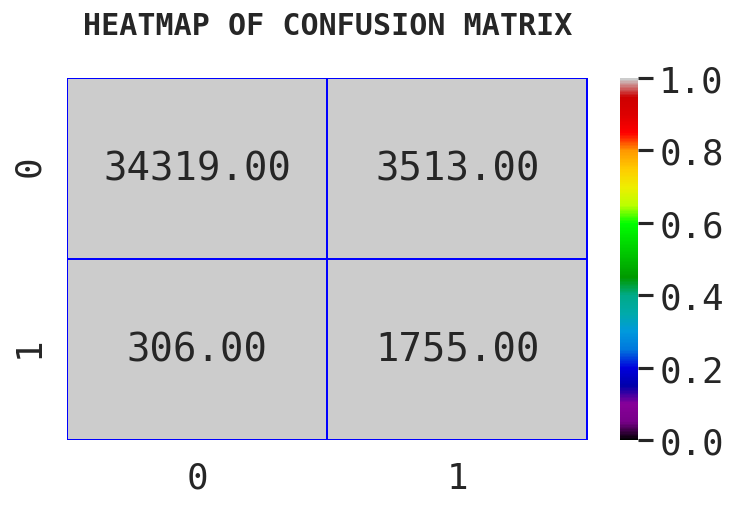



Processing threat
-------------------------------------
ACCURACY SCORE: 0.878224249868398

F1 score: 0.03801980198019802

CLASSIFICATION REPORT:
               precision    recall  f1-score   support

           0       1.00      0.88      0.93     39786
           1       0.02      0.90      0.04       107

    accuracy                           0.88     39893
   macro avg       0.51      0.89      0.49     39893
weighted avg       1.00      0.88      0.93     39893


PRECISION:
 0.019421404005664576

RECALL:
 0.897196261682243

MEAN SQUARED ERROR:
 0.12177575013160204

ROOT MEAN SQ. ERROR:
 0.3489638235284598

LOG_LOSS: 4.206082555215709

AUC_ROC Score:
 0.887684744222713

TPR: [0.         0.12182677 1.        ] 
FPR: [0.         0.89719626 1.        ]




	____________________________________________ROC_AUC CURVE_______________________________________________



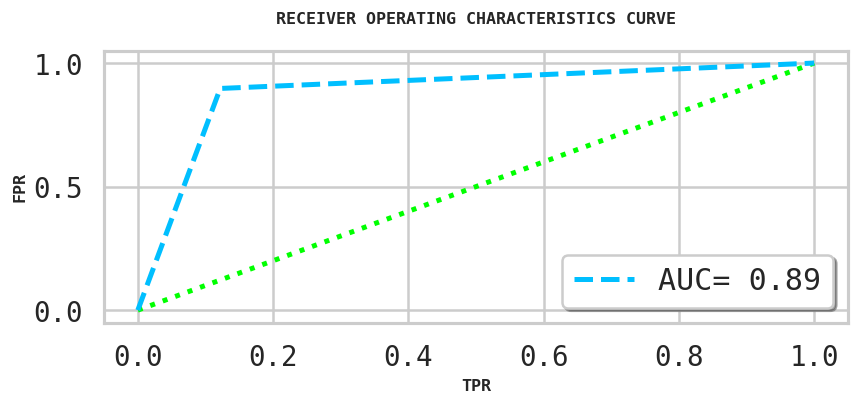





	____________________________________________CONFUSION MATRIX___________________________________________



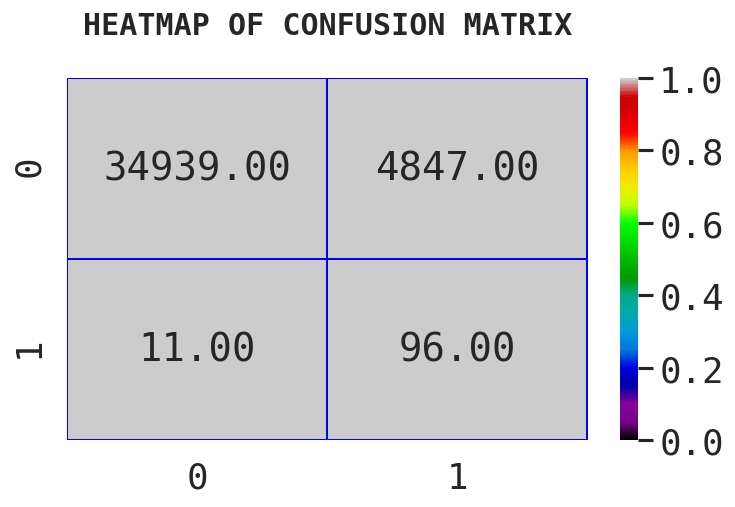



Processing abuse
-------------------------------------
ACCURACY SCORE: 0.8941668964479984

F1 score: 0.43435155412647375

CLASSIFICATION REPORT:
               precision    recall  f1-score   support

           0       0.99      0.90      0.94     37916
           1       0.30      0.82      0.43      1977

    accuracy                           0.89     39893
   macro avg       0.64      0.86      0.69     39893
weighted avg       0.96      0.89      0.92     39893


PRECISION:
 0.29542555130308

RECALL:
 0.8199291856348002

MEAN SQUARED ERROR:
 0.10583310355200161

ROOT MEAN SQ. ERROR:
 0.32532000177056686

LOG_LOSS: 3.6554233871350372

AUC_ROC Score:
 0.8589834766659072

TPR: [0.         0.10196223 1.        ] 
FPR: [0.         0.81992919 1.        ]




	____________________________________________ROC_AUC CURVE_______________________________________________



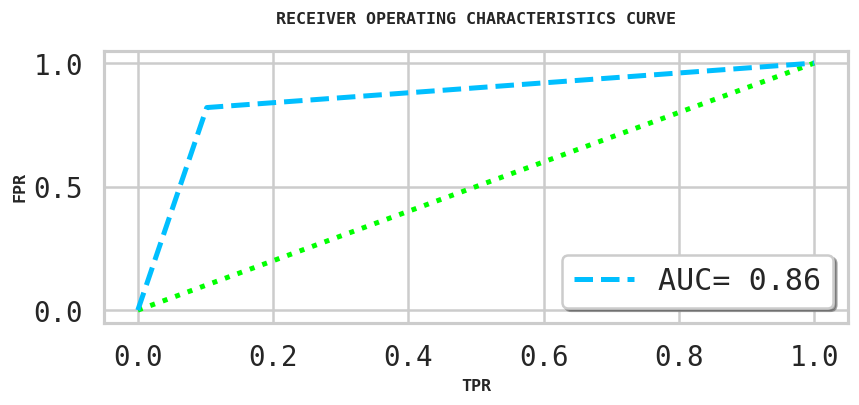





	____________________________________________CONFUSION MATRIX___________________________________________



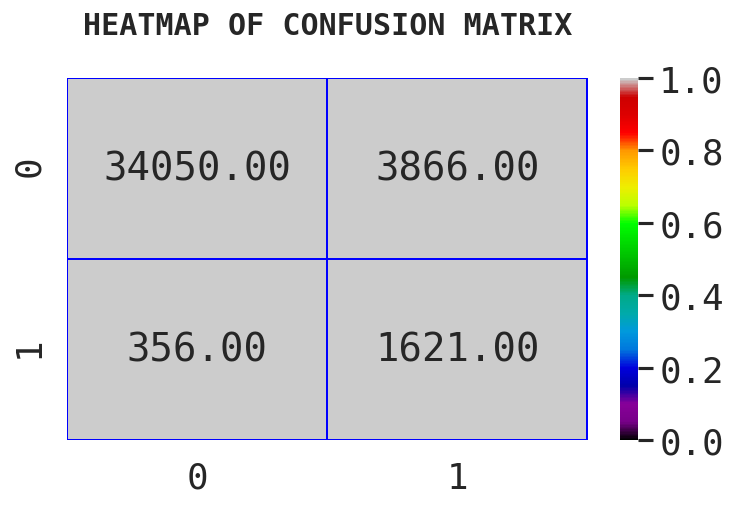



Processing loathe
-------------------------------------
ACCURACY SCORE: 0.8934148848168851

F1 score: 0.12402142562834777

CLASSIFICATION REPORT:
               precision    recall  f1-score   support

           0       1.00      0.89      0.94     39544
           1       0.07      0.86      0.12       349

    accuracy                           0.89     39893
   macro avg       0.53      0.88      0.53     39893
weighted avg       0.99      0.89      0.94     39893


PRECISION:
 0.06681465038845727

RECALL:
 0.8624641833810889

MEAN SQUARED ERROR:
 0.10658511518311484

ROOT MEAN SQ. ERROR:
 0.32647375879711193

LOG_LOSS: 3.681403723429093

AUC_ROC Score:
 0.878076113539624

TPR: [0.         0.10631196 1.        ] 
FPR: [0.         0.86246418 1.        ]




	____________________________________________ROC_AUC CURVE_______________________________________________



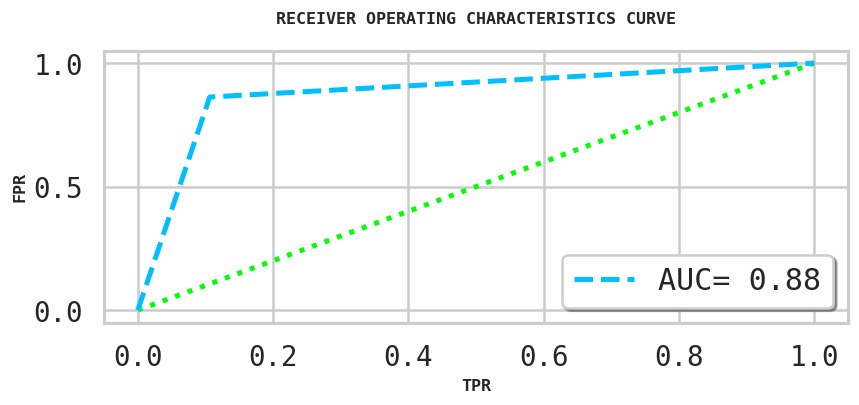





	____________________________________________CONFUSION MATRIX___________________________________________



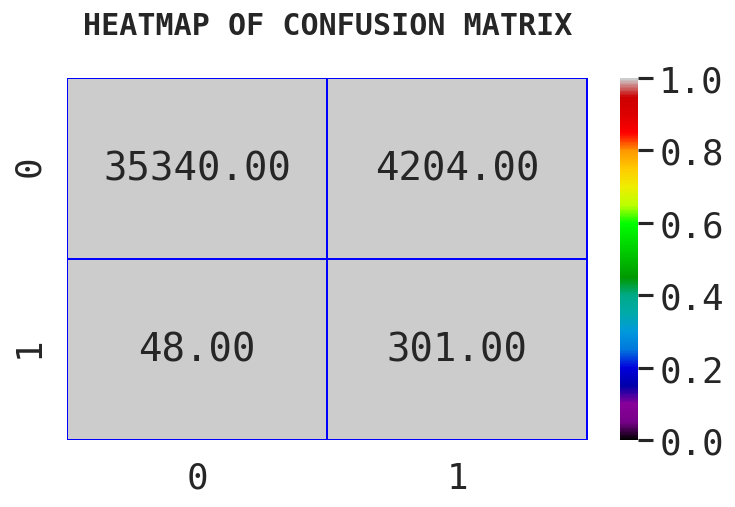



Processing normal
-------------------------------------
ACCURACY SCORE: 0.8502494171909859

F1 score: 0.9110137933089046

CLASSIFICATION REPORT:
               precision    recall  f1-score   support

           0       0.39      0.83      0.53      4013
           1       0.98      0.85      0.91     35880

    accuracy                           0.85     39893
   macro avg       0.68      0.84      0.72     39893
weighted avg       0.92      0.85      0.87     39893


PRECISION:
 0.9784347603506751

RECALL:
 0.8522853957636566

MEAN SQUARED ERROR:
 0.1497505828090141

ROOT MEAN SQ. ERROR:
 0.3869762044480437

LOG_LOSS: 5.1722154040023165

AUC_ROC Score:
 0.8421656233739788

TPR: [0.         0.16795415 1.        ] 
FPR: [0.        0.8522854 1.       ]




	____________________________________________ROC_AUC CURVE_______________________________________________



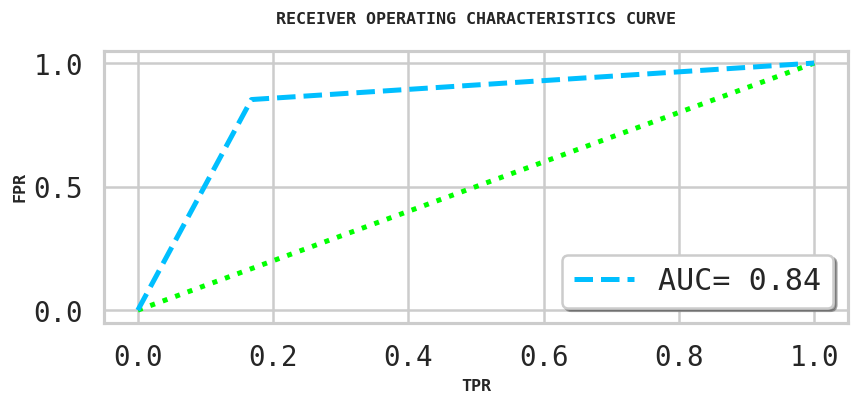





	____________________________________________CONFUSION MATRIX___________________________________________



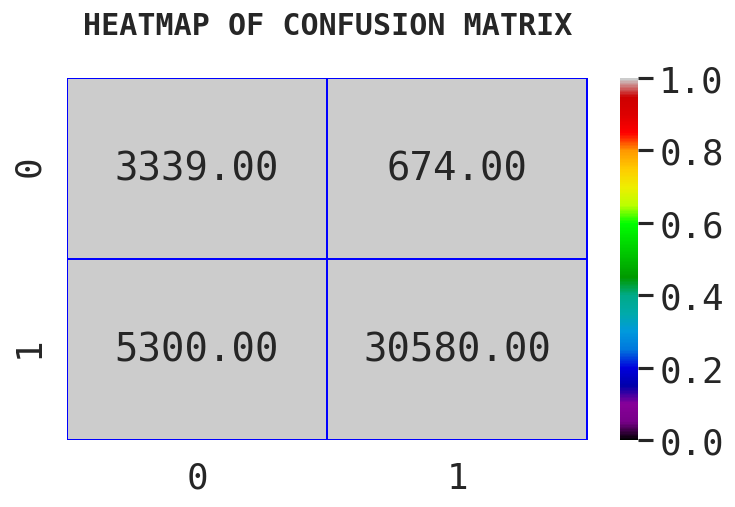

In [71]:
svc_pipeline = Pipeline([('clf', OneVsRestClassifier(ComplementNB(fit_prior=True, class_prior=None), n_jobs=-1))])
F1=[]
ACCURACY = []
PRECESION = []
RECALL = []
RMSE = []
MSE = []
AUC=[]
TPR=[]
FPR=[]
CV_ACC=[]
LOG_LOSS=[]
for category in labels:
    print('Processing {}'.format(category),'\n-------------------------------------')
   
    svc_pipeline.fit(x_train, y_train[category])
    pred = svc_pipeline.predict(x_test)
    f1=f1_score(pred,y_test[category])
    acc=accuracy_score(pred,y_test[category])
    clr=classification_report(y_test[category],pred)
    pre=precision_score(y_test[category],pred)
    rec=recall_score(y_test[category],pred)
    mse=mean_squared_error(y_test[category],pred)
    rmse=np.sqrt(mse)
    log = log_loss( y_test[category],pred)
    auc_scr=roc_auc_score(y_test[category],pred)
    tpr,fpr,threshold=roc_curve(y_test[category],pred)
    conf=confusion_matrix(y_test[category],pred)
        

    print('ACCURACY SCORE:', acc)
    print('\nF1 score:',f1)
    print('\nCLASSIFICATION REPORT:\n',clr)
    print('\nPRECISION:\n',pre)
    print('\nRECALL:\n',rec)
    print('\nMEAN SQUARED ERROR:\n',mse)
    print('\nROOT MEAN SQ. ERROR:\n',rmse)
    print('\nLOG_LOSS:',log)
    print('\nAUC_ROC Score:\n',auc_scr)
    print('\nTPR:',tpr,'\nFPR:',fpr)

    print('\n\n\n\t____________________________________________ROC_AUC CURVE_______________________________________________')

    sns.set(context='talk',style='whitegrid',palette='dark',font='monospace',font_scale=1)
    plt.figure(figsize=(8,3),dpi=120)
    plt.plot([0,1],[0,1],color='lime',linestyle=":",lw=3)
    plt.plot(tpr,fpr,label="AUC= %0.2f" % auc_scr,color='deepskyblue',lw=3,linestyle='--')
    plt.legend(fancybox=True,shadow=True, fontsize='medium')
    
    plt.xlabel("TPR",weight='bold',fontsize=10)
    plt.ylabel('FPR',weight='bold',fontsize=10)
    plt.title('RECEIVER OPERATING CHARACTERISTICS CURVE\n',size=10,weight='bold',loc='center')
    plt.show()

    print('\n\n\n\t____________________________________________CONFUSION MATRIX___________________________________________\n')
    sns.set(context='talk',style='whitegrid',palette='dark',font='monospace',font_scale=1.3)
    plt.figure(figsize=(7,4),dpi=120)
    sns.heatmap(conf,annot=True,fmt='.2f',vmax=1,vmin=0,cmap='nipy_spectral',linewidths=0.8, linecolor='blue')
    plt.title('HEATMAP OF CONFUSION MATRIX\n',size=18,weight='bold',loc='center')
    plt.show()
    print('\n')
    ACCURACY.append(acc)
    F1.append(f1)
    PRECESION.append(pre)
    RECALL.append(rec)
    RMSE.append(rmse)
    MSE.append(mse)
    AUC.append(auc_scr)
    TPR.append(tpr)
    FPR.append(fpr)
    LOG_LOSS.append(log)

lsvc_results = pd.DataFrame({"LABELS":labels,"F1":F1,'Acuracy':ACCURACY,'Precision': PRECESION ,'Recall': RECALL,
                               'RMSE':RMSE,'MSE':MSE,'AUC':AUC,'LOG_LOSS':LOG_LOSS})
lsvc_results.style.set_properties(**{'background-color':'black','color': 'lime','border-color': 'darkorange'})

Processing malignant
-------------------------------------
ACCURACY SCORE: 0.9453538214724387

F1 score: 0.6127886323268206

CLASSIFICATION REPORT:
               precision    recall  f1-score   support

           0       0.95      1.00      0.97     36121
           1       0.93      0.46      0.61      3772

    accuracy                           0.95     39893
   macro avg       0.94      0.73      0.79     39893
weighted avg       0.94      0.95      0.94     39893


PRECISION:
 0.9284176533907428

RECALL:
 0.4573170731707317

MEAN SQUARED ERROR:
 0.05464617852756123

ROOT MEAN SQ. ERROR:
 0.23376522095376212

LOG_LOSS: 1.8874148067922576

AUC_ROC Score:
 0.7268175022839899

TPR: [0.         0.00368207 1.        ] 
FPR: [0.         0.45731707 1.        ]




	____________________________________________ROC_AUC CURVE_______________________________________________



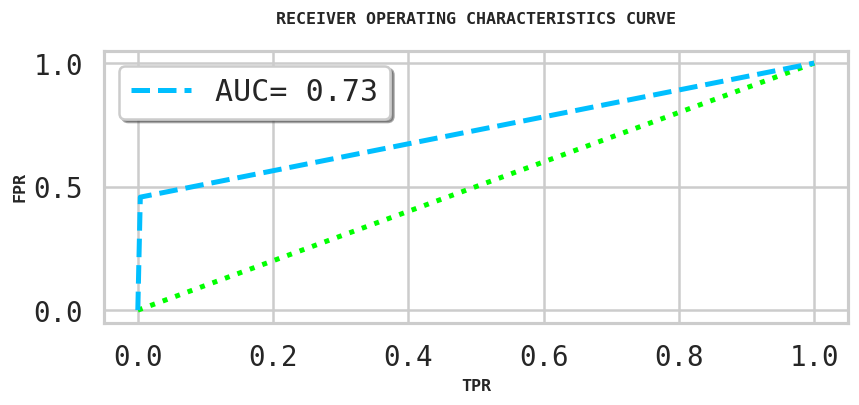





	____________________________________________CONFUSION MATRIX___________________________________________



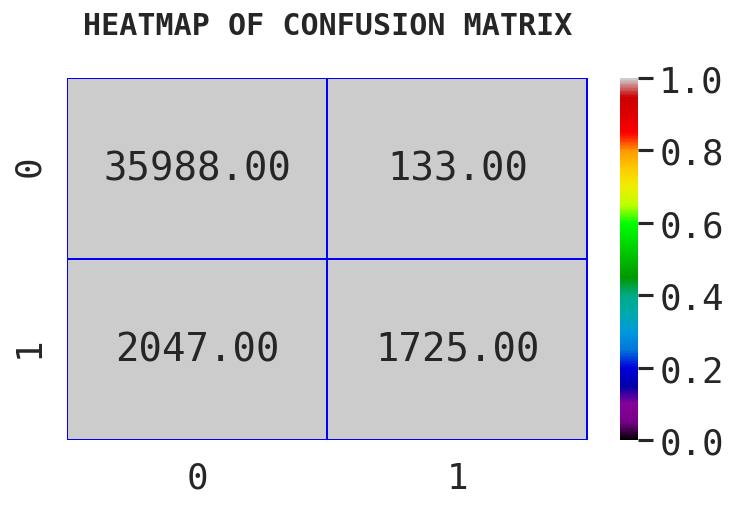



Processing highly_malignant
-------------------------------------
ACCURACY SCORE: 0.990223848795528

F1 score: 0.2471042471042471

CLASSIFICATION REPORT:
               precision    recall  f1-score   support

           0       0.99      1.00      1.00     39532
           1       0.41      0.18      0.25       361

    accuracy                           0.99     39893
   macro avg       0.70      0.59      0.62     39893
weighted avg       0.99      0.99      0.99     39893


PRECISION:
 0.40764331210191085

RECALL:
 0.1772853185595568

MEAN SQUARED ERROR:
 0.009776151204471962

ROOT MEAN SQ. ERROR:
 0.09887442138628151

LOG_LOSS: 0.33765816450445474

AUC_ROC Score:
 0.5874663970112365

TPR: [0.         0.00235252 1.        ] 
FPR: [0.         0.17728532 1.        ]




	____________________________________________ROC_AUC CURVE_______________________________________________



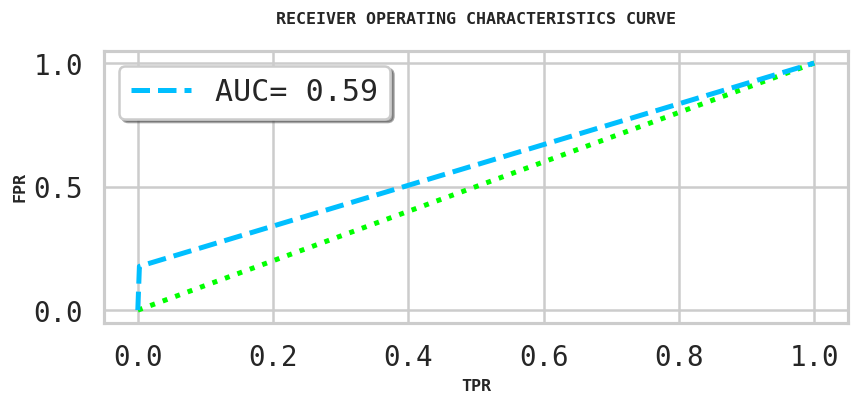





	____________________________________________CONFUSION MATRIX___________________________________________



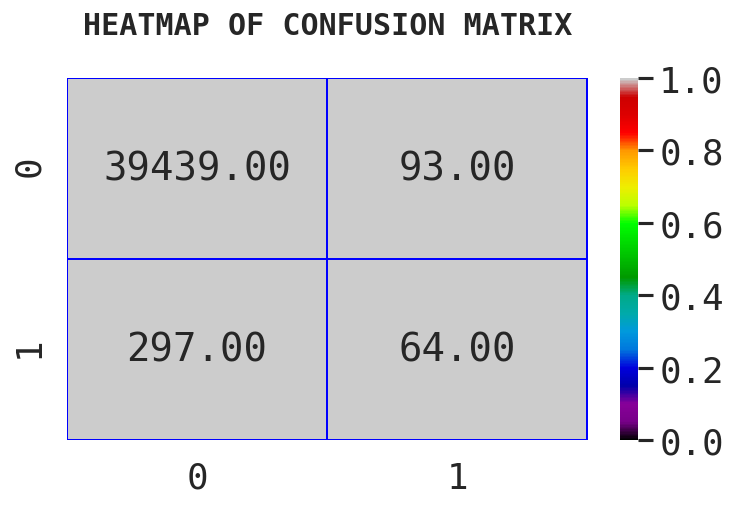



Processing rude
-------------------------------------
ACCURACY SCORE: 0.9759857619131176

F1 score: 0.7259725400457665

CLASSIFICATION REPORT:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99     37832
           1       0.88      0.62      0.73      2061

    accuracy                           0.98     39893
   macro avg       0.93      0.81      0.86     39893
weighted avg       0.97      0.98      0.97     39893


PRECISION:
 0.8843205574912892

RECALL:
 0.6157205240174672

MEAN SQUARED ERROR:
 0.02401423808688241

ROOT MEAN SQ. ERROR:
 0.1549652802626524

LOG_LOSS: 0.8294257268066548

AUC_ROC Score:
 0.8056663520912034

TPR: [0.         0.00438782 1.        ] 
FPR: [0.         0.61572052 1.        ]




	____________________________________________ROC_AUC CURVE_______________________________________________



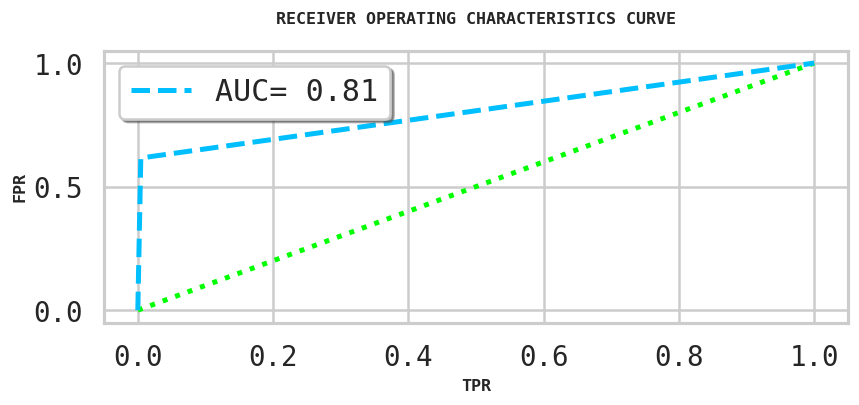





	____________________________________________CONFUSION MATRIX___________________________________________



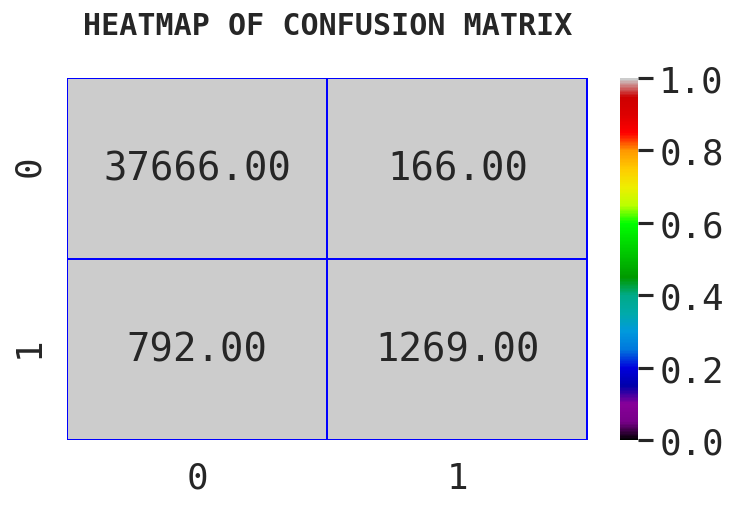



Processing threat
-------------------------------------
ACCURACY SCORE: 0.9970671546386584

F1 score: 0.09302325581395349

CLASSIFICATION REPORT:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     39786
           1       0.27      0.06      0.09       107

    accuracy                           1.00     39893
   macro avg       0.64      0.53      0.55     39893
weighted avg       1.00      1.00      1.00     39893


PRECISION:
 0.2727272727272727

RECALL:
 0.056074766355140186

MEAN SQUARED ERROR:
 0.002932845361341589

ROOT MEAN SQ. ERROR:
 0.054155750953537606

LOG_LOSS: 0.10129721083306525

AUC_ROC Score:
 0.5278363074222793

TPR: [0.00000000e+00 4.02151511e-04 1.00000000e+00] 
FPR: [0.         0.05607477 1.        ]




	____________________________________________ROC_AUC CURVE_______________________________________________



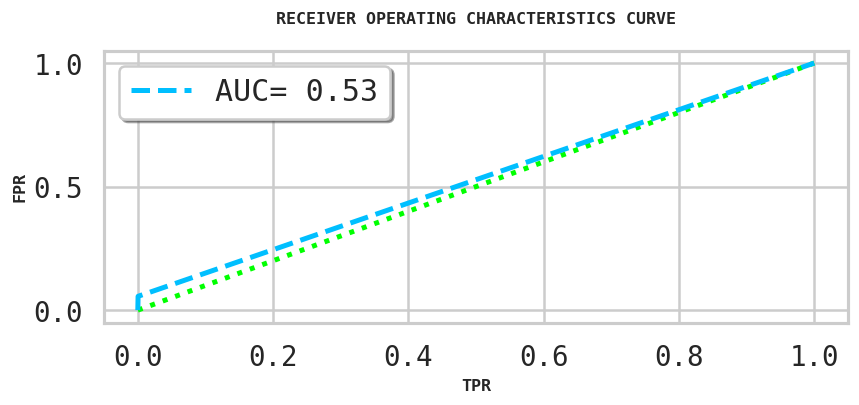





	____________________________________________CONFUSION MATRIX___________________________________________



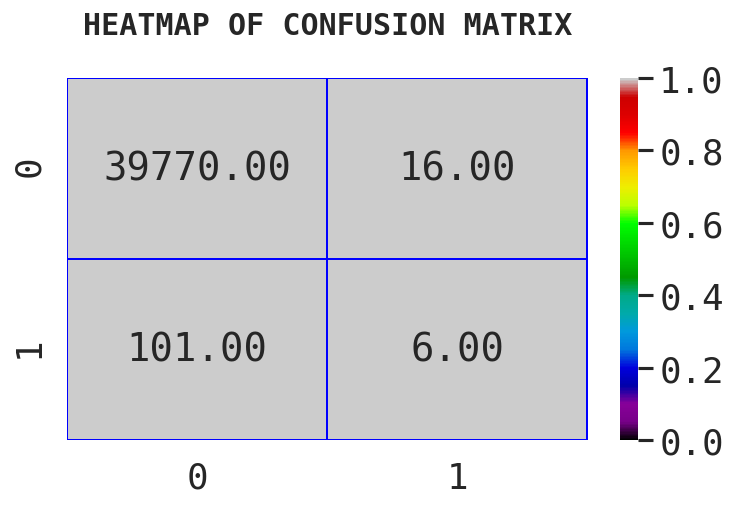



Processing abuse
-------------------------------------
ACCURACY SCORE: 0.9678640362970947

F1 score: 0.6026038437693738

CLASSIFICATION REPORT:
               precision    recall  f1-score   support

           0       0.97      0.99      0.98     37916
           1       0.78      0.49      0.60      1977

    accuracy                           0.97     39893
   macro avg       0.88      0.74      0.79     39893
weighted avg       0.96      0.97      0.96     39893


PRECISION:
 0.77822257806245

RECALL:
 0.49165402124430957

MEAN SQUARED ERROR:
 0.03213596370290527

ROOT MEAN SQ. ERROR:
 0.17926506548378374

LOG_LOSS: 1.109942416633587

AUC_ROC Score:
 0.7421741991441507

TPR: [0.         0.00730562 1.        ] 
FPR: [0.         0.49165402 1.        ]




	____________________________________________ROC_AUC CURVE_______________________________________________



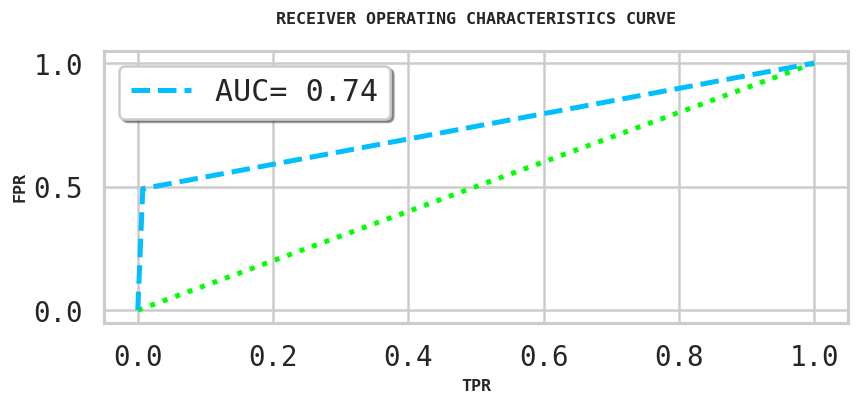





	____________________________________________CONFUSION MATRIX___________________________________________



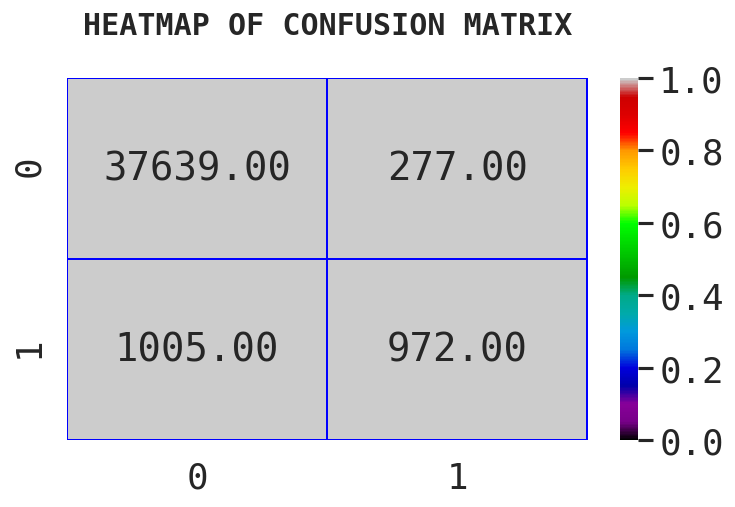



Processing loathe
-------------------------------------
ACCURACY SCORE: 0.9916777379490136

F1 score: 0.30833333333333335

CLASSIFICATION REPORT:
               precision    recall  f1-score   support

           0       0.99      1.00      1.00     39544
           1       0.56      0.21      0.31       349

    accuracy                           0.99     39893
   macro avg       0.78      0.61      0.65     39893
weighted avg       0.99      0.99      0.99     39893


PRECISION:
 0.5648854961832062

RECALL:
 0.21203438395415472

MEAN SQUARED ERROR:
 0.008322262050986389

ROOT MEAN SQ. ERROR:
 0.09122643285247094

LOG_LOSS: 0.2874418905613493

AUC_ROC Score:
 0.6052964758128047

TPR: [0.         0.00144143 1.        ] 
FPR: [0.         0.21203438 1.        ]




	____________________________________________ROC_AUC CURVE_______________________________________________



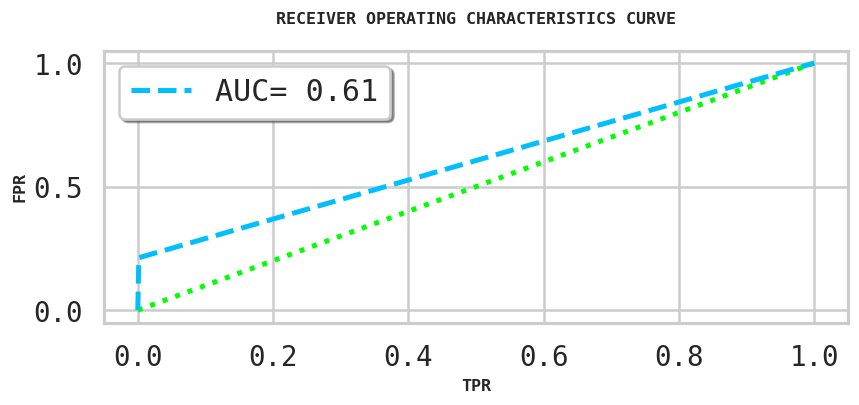





	____________________________________________CONFUSION MATRIX___________________________________________



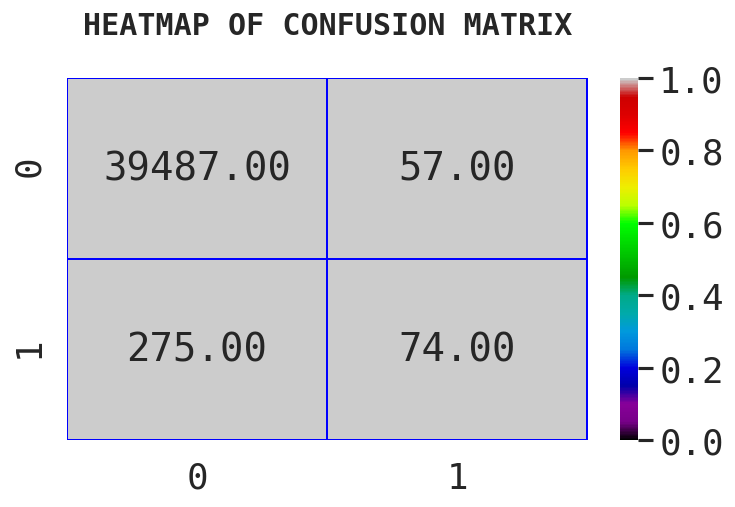



Processing normal
-------------------------------------
ACCURACY SCORE: 0.9434236582859148

F1 score: 0.9694111269228164

CLASSIFICATION REPORT:
               precision    recall  f1-score   support

           0       0.94      0.47      0.62      4013
           1       0.94      1.00      0.97     35880

    accuracy                           0.94     39893
   macro avg       0.94      0.73      0.80     39893
weighted avg       0.94      0.94      0.93     39893


PRECISION:
 0.9435166864529746

RECALL:
 0.9967670011148272

MEAN SQUARED ERROR:
 0.056576341714085175

ROOT MEAN SQ. ERROR:
 0.23785781827403776

LOG_LOSS: 1.954120528950229

AUC_ROC Score:
 0.7316254641756543

TPR: [0.         0.53351607 1.        ] 
FPR: [0.       0.996767 1.      ]




	____________________________________________ROC_AUC CURVE_______________________________________________



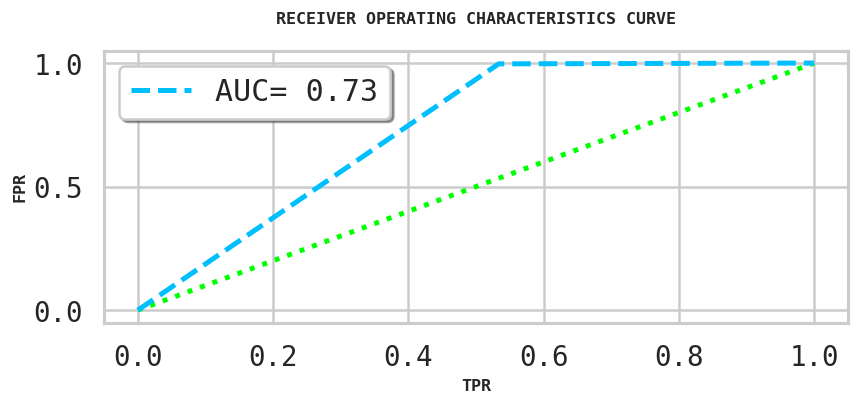





	____________________________________________CONFUSION MATRIX___________________________________________



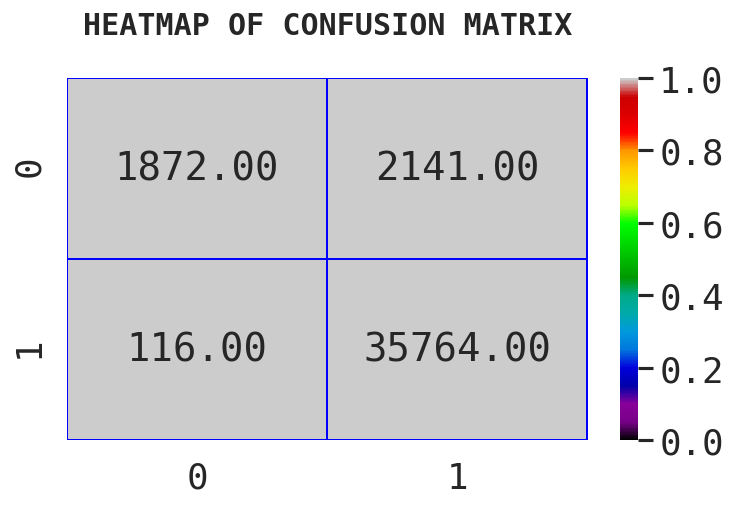

In [72]:
GB_pipeline = Pipeline([('clf', OneVsRestClassifier(GradientBoostingClassifier(),n_jobs=-1))])

F1=[]
ACCURACY = []
PRECESION = []
RECALL = []
RMSE = []
MSE = []
AUC=[]
TPR=[]
FPR=[]
CV_ACC=[]
LOG_LOSS=[]
for category in labels:
    print('Processing {}'.format(category),'\n-------------------------------------')
    
    GB_pipeline.fit(x_train, y_train[category])
    pred = GB_pipeline.predict(x_test)
    f1=f1_score(pred,y_test[category])
    acc=accuracy_score(pred,y_test[category])
    clr=classification_report(y_test[category],pred)
    pre=precision_score(y_test[category],pred)
    rec=recall_score(y_test[category],pred)
    mse=mean_squared_error(y_test[category],pred)
    rmse=np.sqrt(mse)
    log = log_loss( y_test[category],pred)
    auc_scr=roc_auc_score(y_test[category],pred)
    tpr,fpr,threshold=roc_curve(y_test[category],pred)
    conf=confusion_matrix(y_test[category],pred)
        

    print('ACCURACY SCORE:', acc)
    print('\nF1 score:',f1)
    print('\nCLASSIFICATION REPORT:\n',clr)
    print('\nPRECISION:\n',pre)
    print('\nRECALL:\n',rec)
    print('\nMEAN SQUARED ERROR:\n',mse)
    print('\nROOT MEAN SQ. ERROR:\n',rmse)
    print('\nLOG_LOSS:',log)
    print('\nAUC_ROC Score:\n',auc_scr)
    print('\nTPR:',tpr,'\nFPR:',fpr)
    
    print('\n\n\n\t____________________________________________ROC_AUC CURVE_______________________________________________')

    sns.set(context='talk',style='whitegrid',palette='dark',font='monospace',font_scale=1)
    plt.figure(figsize=(8,3),dpi=120)
    plt.plot([0,1],[0,1],color='lime',linestyle=":",lw=3)
    plt.plot(tpr,fpr,label="AUC= %0.2f" % auc_scr,color='deepskyblue',lw=3,linestyle='--')
    plt.legend(fancybox=True,shadow=True, fontsize='medium')
    
    plt.xlabel("TPR",weight='bold',fontsize=10)
    plt.ylabel('FPR',weight='bold',fontsize=10)
    plt.title('RECEIVER OPERATING CHARACTERISTICS CURVE\n',size=10,weight='bold',loc='center')
    plt.show()

    print('\n\n\n\t____________________________________________CONFUSION MATRIX___________________________________________\n')
    sns.set(context='talk',style='whitegrid',palette='dark',font='monospace',font_scale=1.3)
    plt.figure(figsize=(7,4),dpi=120)
    sns.heatmap(conf,annot=True,fmt='.2f',vmax=1,vmin=0,cmap='nipy_spectral',linewidths=0.8, linecolor='blue')
    plt.title('HEATMAP OF CONFUSION MATRIX\n',size=18,weight='bold',loc='center')
    plt.show()
    print('\n')
    ACCURACY.append(acc)
    F1.append(f1)
    PRECESION.append(pre)
    RECALL.append(rec)
    RMSE.append(rmse)
    MSE.append(mse)
    AUC.append(auc_scr)
    TPR.append(tpr)
    FPR.append(fpr)
    LOG_LOSS.append(log)

gb_results = pd.DataFrame({"LABELS":labels,"F1":F1,'Acuracy':ACCURACY,'Precision': PRECESION ,'Recall': RECALL,
                               'RMSE':RMSE,'MSE':MSE,'AUC':AUC,'LOG_LOSS':LOG_LOSS})
gb_results.style.set_properties(**{'background-color':'black','color': 'lime','border-color': 'darkorange'})

###### Model Comparison 

In [73]:
print('\nRESULTS OBTAINED FROM LOGISTIC REGRESSION\n')
display(logi_results)
print('\nRESULTS OBTAINED FROM PASSIVE AGGRESSIVE CLASSIFIER\n')
display(pac_results)
print('\nRESULTS OBTAINED FROM MULTINOMIAL NB CLASSIFIER\n')
display(mnb_results)
print('\nRESULTS OBTAINED FROM COMPLEMENT NB CLASSIFIER\n')
display(cnb_results)
print('\nRESULTS OBTAINED FROM LINER SVC CLASSIFIER\n')
display(lsvc_results)
print('\nRESULTS OBTAINED FROM GRADIENT BOOSTING CLASSIFIER\n')
display(gb_results)


RESULTS OBTAINED FROM LOGISTIC REGRESSION



LABELS        F1   Acuracy  Precision    Recall      RMSE  \
0         malignant  0.681781  0.951445   0.896328  0.550106  0.220352   
1  highly_malignant  0.287938  0.990825   0.483660  0.204986  0.095784   
2              rude  0.734960  0.976587   0.885167  0.628336  0.153012   
3            threat  0.130081  0.997318   0.500000  0.074766  0.051790   
4             abuse  0.603006  0.968215   0.791290  0.487102  0.178284   
5            loathe  0.310345  0.991979   0.626087  0.206304  0.089563   
6            normal  0.972513  0.949490   0.952414  0.993478  0.224745   

        MSE       AUC  LOG_LOSS  
0  0.048555  0.771731  1.677031  
1  0.009175  0.601494  0.316879  
2  0.023413  0.811948  0.808647  
3  0.002682  0.537283  0.092639  
4  0.031785  0.740201  1.097821  
5  0.008021  0.602608  0.277052  
6  0.050510  0.774835  1.744593


RESULTS OBTAINED FROM PASSIVE AGGRESSIVE CLASSIFIER



LABELS        F1   Acuracy  Precision    Recall      RMSE  \
0         malignant  0.635576  0.947309   0.918337  0.485949  0.229545   
1  highly_malignant  0.360882  0.988369   0.358904  0.362881  0.107848   
2              rude  0.736130  0.975560   0.832313  0.659874  0.156334   
3            threat  0.347826  0.996240   0.325203  0.373832  0.061319   
4             abuse  0.603975  0.966535   0.730273  0.514922  0.182933   
5            loathe  0.308642  0.991577   0.547445  0.214900  0.091774   
6            normal  0.961636  0.930840   0.959542  0.963740  0.262983   

        MSE       AUC  LOG_LOSS  
0  0.052691  0.740718  1.819884  
1  0.011631  0.678481  0.401729  
2  0.024440  0.826316  0.844146  
3  0.003760  0.685873  0.129869  
4  0.033465  0.752502  1.155831  
5  0.008423  0.606666  0.290905  
6  0.069160  0.800211  2.388731


RESULTS OBTAINED FROM MULTINOMIAL NB CLASSIFIER



LABELS        F1   Acuracy  Precision    Recall      RMSE  \
0         malignant  0.610182  0.945680   0.949077  0.449629  0.233067   
1  highly_malignant  0.325342  0.990124   0.426009  0.263158  0.099380   
2              rude  0.661760  0.972351   0.899167  0.523532  0.166280   
3            threat  0.017699  0.997218   0.166667  0.009346  0.052749   
4             abuse  0.536159  0.965433   0.800201  0.403136  0.185923   
5            loathe  0.230947  0.991653   0.595238  0.143266  0.091364   
6            normal  0.969197  0.942947   0.942065  0.997938  0.238857   

        MSE       AUC  LOG_LOSS  
0  0.054320  0.723555  1.876159  
1  0.009876  0.629960  0.341122  
2  0.027649  0.760167  0.954964  
3  0.002782  0.504610  0.096102  
4  0.034567  0.698944  1.193922  
5  0.008347  0.571203  0.288307  
6  0.057053  0.724610  1.970572


RESULTS OBTAINED FROM COMPLEMENT NB CLASSIFIER



LABELS        F1   Acuracy  Precision    Recall      RMSE  \
0         malignant  0.539107  0.871932   0.408587  0.792153  0.357865   
1  highly_malignant  0.177242  0.922969   0.098103  0.916898  0.277545   
2              rude  0.478919  0.904269   0.333144  0.851528  0.309404   
3            threat  0.038020  0.878224   0.019421  0.897196  0.348964   
4             abuse  0.434352  0.894167   0.295426  0.819929  0.325320   
5            loathe  0.124021  0.893415   0.066815  0.862464  0.326474   
6            normal  0.911014  0.850249   0.978435  0.852285  0.386976   

        MSE       AUC  LOG_LOSS  
0  0.128068  0.836208  4.423384  
1  0.077031  0.919961  2.660619  
2  0.095731  0.879335  3.306505  
3  0.121776  0.887685  4.206083  
4  0.105833  0.858983  3.655423  
5  0.106585  0.878076  3.681404  
6  0.149751  0.842166  5.172215


RESULTS OBTAINED FROM LINER SVC CLASSIFIER



LABELS        F1   Acuracy  Precision    Recall      RMSE  \
0         malignant  0.539107  0.871932   0.408587  0.792153  0.357865   
1  highly_malignant  0.177242  0.922969   0.098103  0.916898  0.277545   
2              rude  0.478919  0.904269   0.333144  0.851528  0.309404   
3            threat  0.038020  0.878224   0.019421  0.897196  0.348964   
4             abuse  0.434352  0.894167   0.295426  0.819929  0.325320   
5            loathe  0.124021  0.893415   0.066815  0.862464  0.326474   
6            normal  0.911014  0.850249   0.978435  0.852285  0.386976   

        MSE       AUC  LOG_LOSS  
0  0.128068  0.836208  4.423384  
1  0.077031  0.919961  2.660619  
2  0.095731  0.879335  3.306505  
3  0.121776  0.887685  4.206083  
4  0.105833  0.858983  3.655423  
5  0.106585  0.878076  3.681404  
6  0.149751  0.842166  5.172215


RESULTS OBTAINED FROM GRADIENT BOOSTING CLASSIFIER



LABELS        F1   Acuracy  Precision    Recall      RMSE  \
0         malignant  0.612789  0.945354   0.928418  0.457317  0.233765   
1  highly_malignant  0.247104  0.990224   0.407643  0.177285  0.098874   
2              rude  0.725973  0.975986   0.884321  0.615721  0.154965   
3            threat  0.093023  0.997067   0.272727  0.056075  0.054156   
4             abuse  0.602604  0.967864   0.778223  0.491654  0.179265   
5            loathe  0.308333  0.991678   0.564885  0.212034  0.091226   
6            normal  0.969411  0.943424   0.943517  0.996767  0.237858   

        MSE       AUC  LOG_LOSS  
0  0.054646  0.726818  1.887415  
1  0.009776  0.587466  0.337658  
2  0.024014  0.805666  0.829426  
3  0.002933  0.527836  0.101297  
4  0.032136  0.742174  1.109942  
5  0.008322  0.605296  0.287442  
6  0.056576  0.731625  1.954121

###### Choosing final MOdel

Choosing Logitic Regrestion as final model because its Accuracy Score is high.

###### Saving MOdel

In [82]:
joblib.dump(LogReg_pipeline,'Comments.pkl')
print('MOdle Saved')

MOdle Saved


###### Prediction

In [83]:
#loading the model
model=joblib.load('Comments.pkl')

In [84]:
test.head()

comment_text  \
0  Yo bitch Ja Rule is more succesful then you'll...   
1  == From RfC == \n\n The title is fine as it is...   
2  " \n\n == Sources == \n\n * Zawe Ashton on Lap...   
3  :If you have a look back at the source, the in...   
4          I don't anonymously edit articles at all.   

                                             comment  
0  bitch rule succes ever hate sad mofuckasi bitc...  
1                                  rfc titl fine imo  
2                           sourc zaw ashton lapland  
3  look sourc inform updat correct form guess sou...  
4                                 anonym edit articl

In [85]:
X=test['comment']
X

0         bitch rule succes ever hate sad mofuckasi bitc...
1                                         rfc titl fine imo
2                                  sourc zaw ashton lapland
3         look sourc inform updat correct form guess sou...
4                                        anonym edit articl
                                ...                        
153159                    total agre stuff noth toolongcrap
153160    throw field home plate faster throw cut man di...
153161    categori chang agre correct gotten confus foun...
153162    one found nation germani law return quit simil...
153163    stop alreadi bullshit welcom fool think kind e...
Name: comment, Length: 153164, dtype: object

In [91]:
tfidf=tf(input='content', encoding='utf-8', lowercase=True,stop_words='english',max_features=1000,ngram_range=(1,3))
test_x=tfidf.fit_transform(X)

In [92]:
test_x.shape

(153164, 1000)

In [93]:
result=model.predict(test_x)

In [94]:
display(result)

array([1, 1, 1, ..., 1, 1, 1], dtype=int64)